In [2]:
# Enable autoreloading of modules
%load_ext autoreload
%autoreload 2

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Standard imports
import os
import sys
import random

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning tools and models
from sklearn.model_selection import (cross_val_score, StratifiedKFold, StratifiedGroupKFold,
                                     train_test_split, KFold, GroupShuffleSplit)
from sklearn.metrics import (roc_auc_score, confusion_matrix, classification_report,
                             f1_score, )
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder



# Custom utilities
sys.path.append('../')
from src.utils import load_config, split_into_sentences, flatten_list, load_and_clean_data
from src import stats_analysis as sa
from src.data_cleaning import add_average_data
from src.ml_utils import train_and_evaluate_rf, train_and_evaluate_xgb, filter_dataset

#proportion score matching
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Exploration

### a.  Data Loading

In [3]:
config = load_config('../config.yaml')
data = load_and_clean_data(config)
data = add_average_data(data)
print(data.temperature_enc.value_counts())
print(data.has_paraphrase.value_counts())

Data contains at the begining : 18039
Filtering data with more than 20 sentences and less than 5 sentences. 18039 samples left
Filtering data with phone numbers. 18039 samples left
Filtering data with addresses. 18039 samples left
Filtering data with mail addresses. 18039 samples left
Filtering data with list. 18039 samples left
Filtering data with short paraphrase. 18039 samples left
Filtering data with paraphrase at the end. 18039 samples left
temperature_enc
medium_temperature    6416
low_temperature       6191
high_temperature      5432
Name: count, dtype: int64
has_paraphrase
0    9375
1    8664
Name: count, dtype: int64


In [5]:
## une only low and medium example

dataset = data[data.temperature_enc.isin(["low_temperature","medium_temperature"])]
print(dataset.temperature_enc.value_counts())
print(dataset.has_paraphrase.value_counts())
print(len(dataset))

temperature_enc
medium_temperature    6416
low_temperature       6191
Name: count, dtype: int64
has_paraphrase
0    6646
1    5961
Name: count, dtype: int64
12607


In [22]:
dataset['prompt_cat']

0        2
1        2
2        2
3        2
4        2
        ..
16641    1
16642    1
16643    1
16644    1
16645    1
Name: prompt_cat, Length: 12607, dtype: int8

In [25]:
# Low temperature + no paraphrase
print("## Example of sentence with low temperature and no paraphrase")
print(
    dataset[
        (dataset['has_paraphrase'] == 0)
        & (dataset["temperature_enc"] == "low_temperature")
        & (dataset["prompt_cat"] == 2)
    ]['altered_text'].sample(1).values[0]
)

# Low temperature + with paraphrase
print("\n## Example of sentence with low temperature and with paraphrase")
print(
    dataset[
        (dataset['has_paraphrase'] == 1)
        & (dataset["temperature_enc"] == "low_temperature")
        & (dataset["prompt_cat"] == 2)
    ]['altered_text'].sample(1).values[0]
)

# Medium temperature + no paraphrase
print("\n## Example of sentence with medium temperature and no paraphrase")
print(
    dataset[
        (dataset['has_paraphrase'] == 0)
        & (dataset["temperature_enc"] == "medium_temperature")
        & (dataset["prompt_cat"] == 2)
    ]['altered_text'].sample(1).values[0]
)

# Medium temperature + with paraphrase
print("\n## Example of sentence with medium temperature and with paraphrase")
print(
    dataset[
        (dataset['has_paraphrase'] == 1)
        & (dataset["temperature_enc"] == "medium_temperature")
        & (dataset["prompt_cat"] == 2)
    ]['altered_text'].sample(1).values[0]
)

## Example of sentence with low temperature and no paraphrase
Most people start the day by going to work and then come home to eat.Its a good way to get to know your neighbors and it gives you a chance to socialize with them.If youre not in the habit of doing that it can be a little awkward at first.But after a while you wont have to think about it.Youll just get used to it and enjoy the company of your friends.Here are some tips to help you get started1.Donts Dont make a big deal out of it but dontdo some small things.For example if you go to a party make sure you bring something to drink.And if someone invites you to their house dont just say Id love to come over.Instead say something like I would really like to see your house

## Example of sentence with low temperature and with paraphrase
Most people start the day by having a cup of coffee.Its a great way to start your day.If youre not a coffee drinker dont worry.You can still enjoy your morning coffee with a little cream and sugar

### b. Define set of features for experiments

In [26]:
global_topic_structure_features = [
        'cluster_density_score_MeanShift',
        'cluster_reverse_silhouette_score_MeanShift']

# Local Topic Structure
local_topic_structure_features = [
        'cluster_density_score_HDBSCAN',
        'cluster_reverse_silhouette_score_HDBSCAN']

# Semantic Complexity
semantic_complexity_features = [
        'reduction_score_PCA_explained_variance',
        'regression_error_score_Lasso']

density = global_topic_structure_features + local_topic_structure_features + semantic_complexity_features + ['narrative_speed_score']
density_average = ["semantic_complexity", "local_topic_structure", "global_topic_structure", "narrative_speed_score"]

cosine_mean_sim_metrics = data.filter(regex = '(sentence_sim|w2v|glove|fast_text)_(all|consecutive)_(cosine)(.*)(mean)').columns.tolist()
wmd_mean_sim_metrics = data.filter(regex = '(sentence_sim|w2v|glove|fast_text)_(all|consecutive)_(wmd)(.*)(mean)').columns.tolist()

mean_sim_metrics = cosine_mean_sim_metrics + wmd_mean_sim_metrics

sim_average  = ["all_cosine_sentences_similarity_mean","consecutive_cosine_sentences_similarity_mean","all_wmd_sentences_similarity_mean", "consecutive_wmd_sentences_similarity_mean",]

all_features = density + cosine_mean_sim_metrics + wmd_mean_sim_metrics

features_dict = {
        "density_features": density,
        "density_average": density_average,
        "cosine_mean_sim_metrics": cosine_mean_sim_metrics,
        "wmd_mean_sim_metrics": wmd_mean_sim_metrics,
        "mean_sim_metrics": cosine_mean_sim_metrics + wmd_mean_sim_metrics,
        "sim_average": sim_average,
        "all_features": all_features,
        "all_average_features": density_average + sim_average,
    }

best_parameters_dict = {
    "density_features": {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True},
    "density_average": {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True},
    "cosine_mean_sim_metrics" : {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': True},
    "wmd_mean_sim_metrics" : {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True},
    "mean_sim_metrics" : {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': True},
    "sim_average" : {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False},
    "all_features" : {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': False} ,
    "all_average_features" : {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True},
    "density_without_narrative_speed" : {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True},
}

for key, elt in features_dict.items():
    print(f" {key} : {len(elt)}, {','.join(elt)}")


 density_features : 7, cluster_density_score_MeanShift,cluster_reverse_silhouette_score_MeanShift,cluster_density_score_HDBSCAN,cluster_reverse_silhouette_score_HDBSCAN,reduction_score_PCA_explained_variance,regression_error_score_Lasso,narrative_speed_score
 density_average : 4, semantic_complexity,local_topic_structure,global_topic_structure,narrative_speed_score
 cosine_mean_sim_metrics : 8, w2v_consecutive_cosine_sentences_similarity_mean,w2v_all_cosine_sentences_similarity_mean,fast_text_consecutive_cosine_sentences_similarity_mean,fast_text_all_cosine_sentences_similarity_mean,glove_consecutive_cosine_sentences_similarity_mean,glove_all_cosine_sentences_similarity_mean,sentence_sim_consecutive_cosine_sentences_similarity_mean,sentence_sim_all_cosine_sentences_similarity_mean
 wmd_mean_sim_metrics : 6, w2v_all_wmd_sentences_similarity_mean,w2v_consecutive_wmd_sentences_similarity_mean,fast_text_all_wmd_sentences_similarity_mean,fast_text_consecutive_wmd_sentences_similarity_mean,g

### c. Data description
#### c.1 density metrics

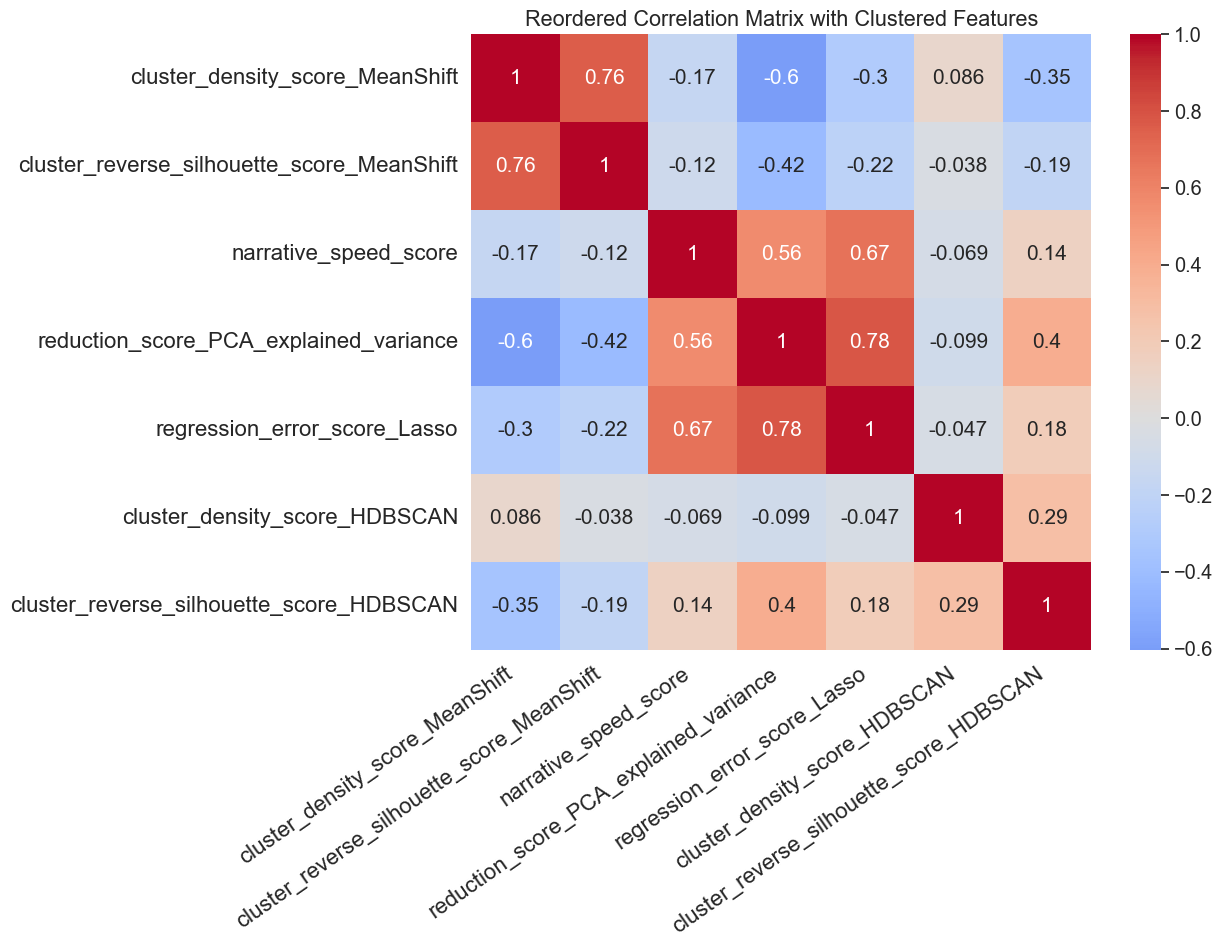

In [27]:
from scipy.cluster.hierarchy import linkage, leaves_list

data_dense = data[density]


corr_matrix = data_dense.corr(method='spearman')

linkage_matrix = linkage(corr_matrix, method='average')

# Step 3: Reorder the correlation matrix
# Get the order of the leaves
order = leaves_list(linkage_matrix)

# Reorder the correlation matrix according to the hierarchical clustering
reordered_corr_matrix = corr_matrix.iloc[order, order]

# Reorder the correlation matrix according to the hierarchical clustering
reordered_corr_matrix = corr_matrix.iloc[order, order]

# Step 4: Visualize the reordered correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(reordered_corr_matrix, annot=True, cmap='coolwarm', center=0, annot_kws={"size": 15})
plt.xticks(rotation=35, ha='right', fontsize=16)  # Change x-axis label font size here
plt.yticks(fontsize=16)
plt.title('Reordered Correlation Matrix with Clustered Features')
plt.show()

## I. 6 classes classification problem

In [31]:
label_encoded_dict = {
    'low_temperature_with_paraphrase': 0,
    'low_temperature_with_no_paraphrase': 1,
    "medium_temperature_with_paraphrase": 2,
    "medium_temperature_with_no_paraphrase": 3,
    #"high_temperature_with_paraphrase": 4,
    #"high_temperature_with_no_paraphrase": 5
}

num_to_label = {v: k for k, v in label_encoded_dict.items()}

dataset = dataset.sample(frac = 1).copy()
dataset = dataset[~dataset[mean_sim_metrics].isin([-1]).any(axis=1)]



dataset['cat_label'] = dataset.combined_label.map(label_encoded_dict)#.apply(int)
dataset['cat_label'].value_counts()

print(dataset.combined_label.value_counts())


combined_label
medium_temperature_with_no_paraphrase    3368
low_temperature_with_no_paraphrase       3236
medium_temperature_with_paraphrase       3027
low_temperature_with_paraphrase          2908
Name: count, dtype: int64


In [ ]:
plot = True
compute_context_auc  = False
error_type = True
df_results = train_and_evaluate_xgb(features_dict, dataset, y_name="cat_label", num_to_label = num_to_label, plot = plot, compute_context_auc=compute_context_auc, plot_error_type=error_type)
df_results.sort_values(by = "f1_score", ascending = False)
df_results[['features_name','accuracy','f1_score']].sort_values(by = "f1_score", ascending = False)

########################################
Running feature set: density_features
density_features -> Accuracy: 0.4568 ± 0.0179 | F1 (weighted): 0.4546 ± 0.0210


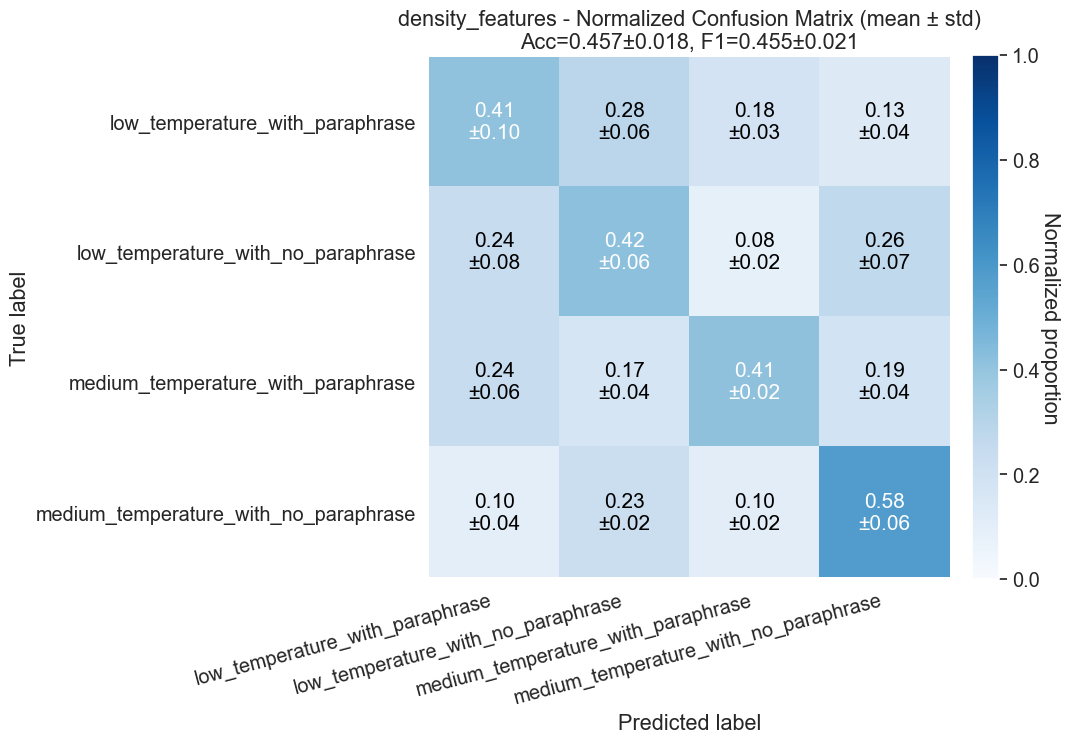

########################################
Running feature set: cosine_mean_sim_metrics
cosine_mean_sim_metrics -> Accuracy: 0.3387 ± 0.0131 | F1 (weighted): 0.3335 ± 0.0149


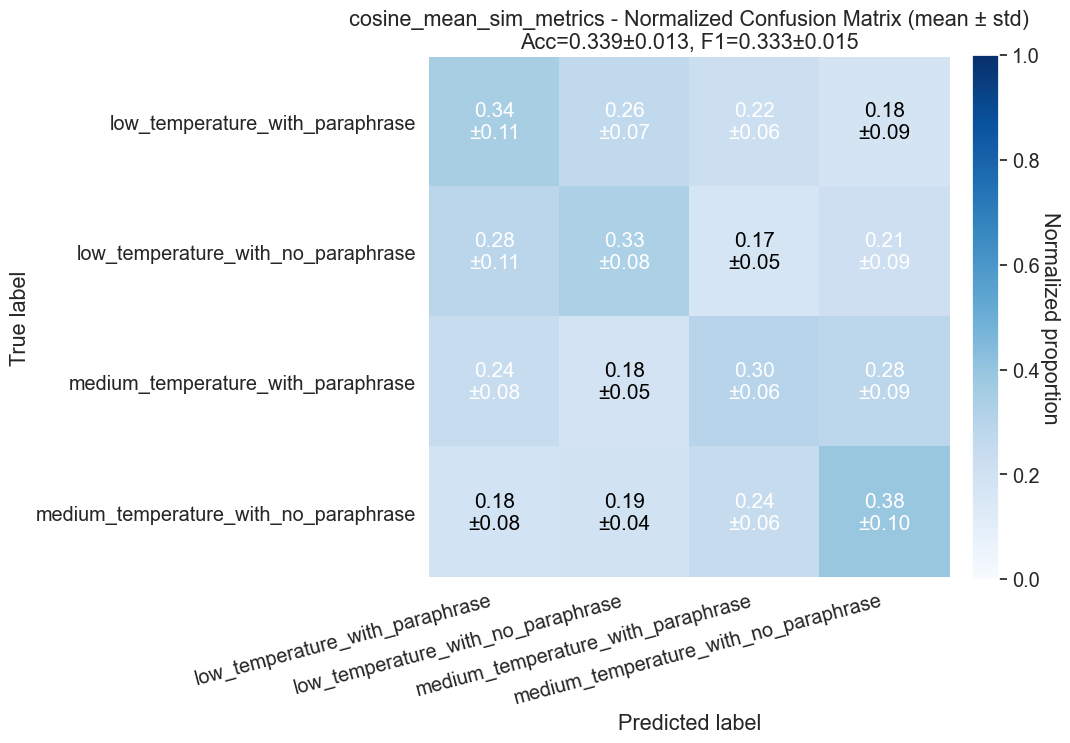

########################################
Running feature set: all_features
all_features -> Accuracy: 0.5029 ± 0.0163 | F1 (weighted): 0.4976 ± 0.0203


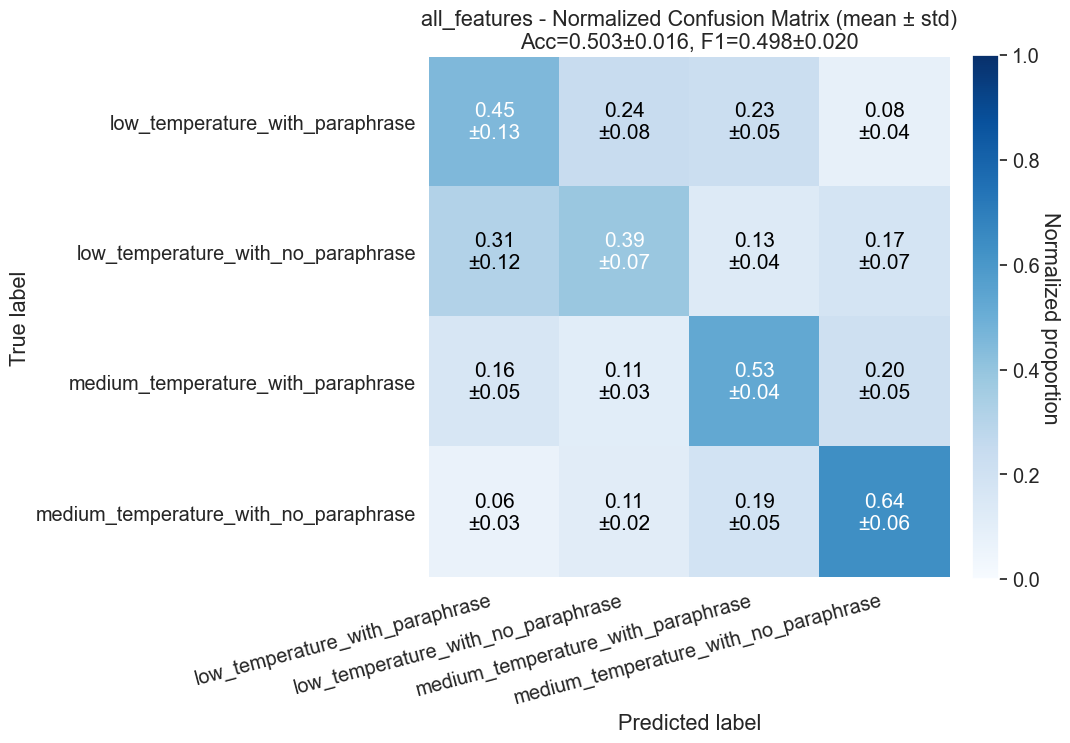


SUMMARY (sorted by f1_mean):
             features_name  accuracy_mean  accuracy_std   f1_mean    f1_std
0             all_features       0.502879      0.016287  0.497588  0.020318
1         density_features       0.456848      0.017870  0.454600  0.020961
2  cosine_mean_sim_metrics       0.338656      0.013090  0.333452  0.014898


In [ ]:
## average results

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

warnings.filterwarnings("ignore")  # optional

def plot_confusion_matrix_stats(mean_cm, std_cm, num_to_label, title=None, cmap=plt.cm.Blues):
    """
    Plot mean_cm with each cell annotated as "mean ± std".
    mean_cm and std_cm are 2D arrays with shape (n_classes, n_classes).
    num_to_label: dict mapping integer label -> string name (e.g. {0: 'low_with_p', ...})
    """
    label_order = sorted(num_to_label.keys())
    classes = [num_to_label[i] for i in label_order]
    n = len(classes)

    

    fig, ax = plt.subplots(figsize=(10, 8))

    # Draw the heatmap with no interpolation (prevents white seams) and equal aspect
    im = ax.imshow(mean_cm, interpolation='nearest', cmap=cmap, aspect='equal', vmin=0.0, vmax=1.0)

    # remove grid and spines that can create white lines
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # ticks and labels
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(classes, rotation=15, ha='right', fontsize = 20)
    ax.set_yticklabels(classes, fontsize = 20)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    if title is not None:
        ax.set_title(title)

    # colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Normalized proportion', rotation=270, labelpad=15)

    # Annotate each cell with mean ± std
    vmax = mean_cm.max() if mean_cm.size else 1.0
    for i in range(n):
        for j in range(n):
            mean_val = mean_cm[i, j]
            std_val = std_cm[i, j]
            text = f"{mean_val:.2f}\n±{std_val:.2f}"
            # choose text color for contrast
            text_color = "white" if mean_val > vmax / 2 else "black"
            ax.text(j, i, text, ha='center', va='center', color=text_color, fontsize=20)

    plt.tight_layout()
    plt.show()

def run_experiment_over_seeds(features_dict,
                              best_parameters_dict,
                              data,
                              y_name="cat_label",
                              num_to_label=None,
                              seeds=None,
                              n_splits_test_size=0.2,
                              plot_conf_matrices=True):
    """
    Runs experiments over multiple seeds and computes mean +/- std for accuracy, f1 and confusion matrices.
    num_to_label: dict mapping integer label -> string label name (required).
    """
    if num_to_label is None:
        raise ValueError("num_to_label (dict mapping int->label name) must be provided")

    # stable, reproducible ordering of integer labels
    label_order = sorted(num_to_label.keys())
    class_names = [num_to_label[i] for i in label_order]

    if seeds is None:
        seeds = np.random.RandomState(42).randint(0, 10**6, size=100)
    else:
        seeds = np.array(seeds)

    summary_rows = []
    cm_stats = {}

    for features_name, features in features_dict.items():
        accs = []
        f1s = []
        cms_norm = []  # store per-seed row-normalized confusion matrices

        parameters = best_parameters_dict[features_name]
        print("#" * 40)
        print(f"Running feature set: {features_name}")

        X = data[features]
        y = data[y_name]

        for seed in seeds:
            clf = RandomForestClassifier(**parameters, random_state=int(seed))

            gss = GroupShuffleSplit(n_splits=1, test_size=n_splits_test_size, random_state=int(seed))
            train_index, test_index = next(gss.split(data, groups=data['prompt_cat']))

            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

            accs.append(acc)
            f1s.append(f1)

            # build confusion matrix with fixed label ordering (ensures matrix shape stable)
            cm = confusion_matrix(y_test, y_pred, labels=label_order)

            # Row-normalize (per true-label / row). Handle rows with sum 0.
            row_sums = cm.sum(axis=1, keepdims=True).astype(float)
            with np.errstate(divide='ignore', invalid='ignore'):
                cm_norm = np.divide(cm, row_sums, where=(row_sums != 0))
                cm_norm = np.nan_to_num(cm_norm)
            cms_norm.append(cm_norm)

        # Convert lists to arrays for stats
        accs = np.array(accs)
        f1s = np.array(f1s)
        cms_norm = np.stack(cms_norm, axis=0)  # shape (n_seeds, n_classes, n_classes)

        acc_mean, acc_std = accs.mean(), accs.std(ddof=1)
        f1_mean, f1_std = f1s.mean(), f1s.std(ddof=1)

        mean_cm = cms_norm.mean(axis=0)
        std_cm = cms_norm.std(axis=0, ddof=1)

        summary_rows.append({
            "features_name": features_name,
            "accuracy_mean": acc_mean,
            "accuracy_std": acc_std,
            "f1_mean": f1_mean,
            "f1_std": f1_std
        })

        cm_stats[features_name] = {
            "mean_cm": mean_cm,
            "std_cm": std_cm,
            "label_order": label_order,
            "class_names": class_names
        }

        print(f"{features_name} -> Accuracy: {acc_mean:.4f} ± {acc_std:.4f} | F1 (weighted): {f1_mean:.4f} ± {f1_std:.4f}")

        # Plot confusion matrix annotated with mean ± std (pass the mapping dict, not a list)
        if plot_conf_matrices:
            title = f"{features_name} - Normalized Confusion Matrix (mean ± std)\nAcc={acc_mean:.3f}±{acc_std:.3f}, F1={f1_mean:.3f}±{f1_std:.3f}"
            plot_confusion_matrix_stats(mean_cm, std_cm, num_to_label=num_to_label, title=title)

    summary_df = pd.DataFrame(summary_rows).sort_values(by='f1_mean', ascending=False).reset_index(drop=True)
    return summary_df, cm_stats

# USAGE EXAMPLE:
seeds = np.random.RandomState(42).randint(0, 10**6, size=100)  # optional custom seeds
features_dict_test = {
        "density_features": density,

        "cosine_mean_sim_metrics": cosine_mean_sim_metrics,
        
        "all_features": all_features,
        
    }

#print(num_to_label)

summary_df, cm_stats = run_experiment_over_seeds(
    features_dict=features_dict_test,
    best_parameters_dict=best_parameters_dict,
    data=dataset,
    y_name="cat_label",
    num_to_label=num_to_label,
    seeds=seeds,   # None -> uses 100 reproducible pseudo-random seeds
    n_splits_test_size=0.2,
    plot_conf_matrices=True
)

print("\nSUMMARY (sorted by f1_mean):")
print(summary_df[['features_name', 'accuracy_mean', 'accuracy_std', 'f1_mean', 'f1_std']])


########################################
Training with density_features
Accuracy: 0.4712114233072317
F1 Score: 0.46941341909846473


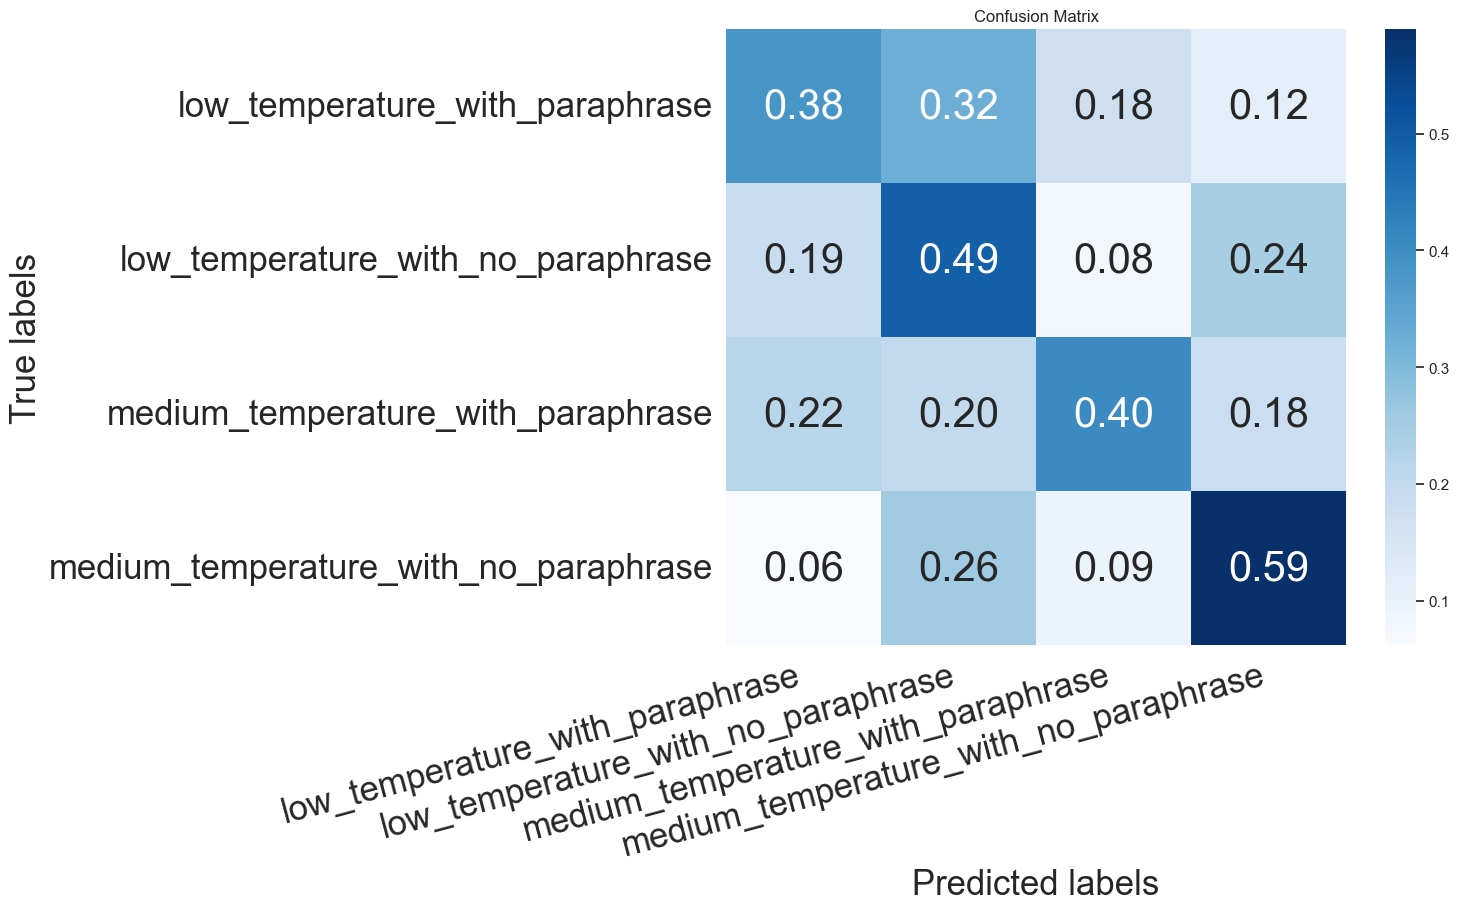

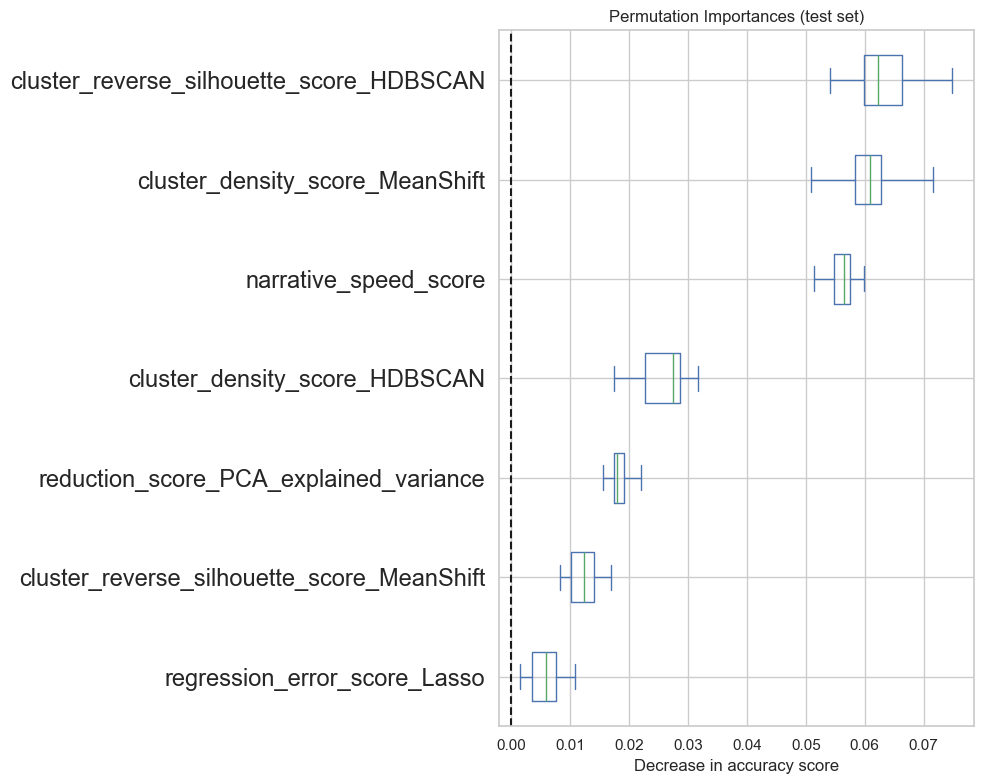

possible_misclassifications_paraphrase_only 4342
error_paraphrase_only 838
possible_misclassifications_temperature_only 4342
error_temperature_only 977
possible_misclassifications_fail_dissociate 2164
error_fail_dissociate 290


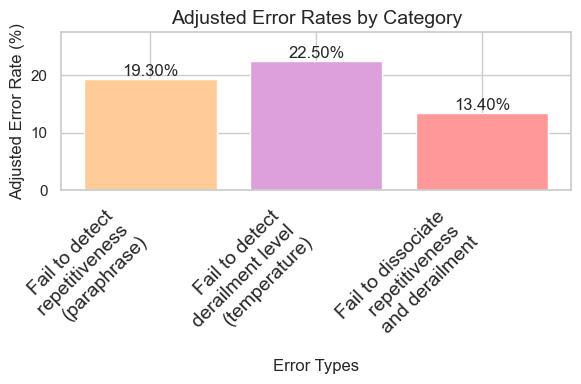

########################################
Training with density_average
Accuracy: 0.42952556425610317
F1 Score: 0.4267504201254905


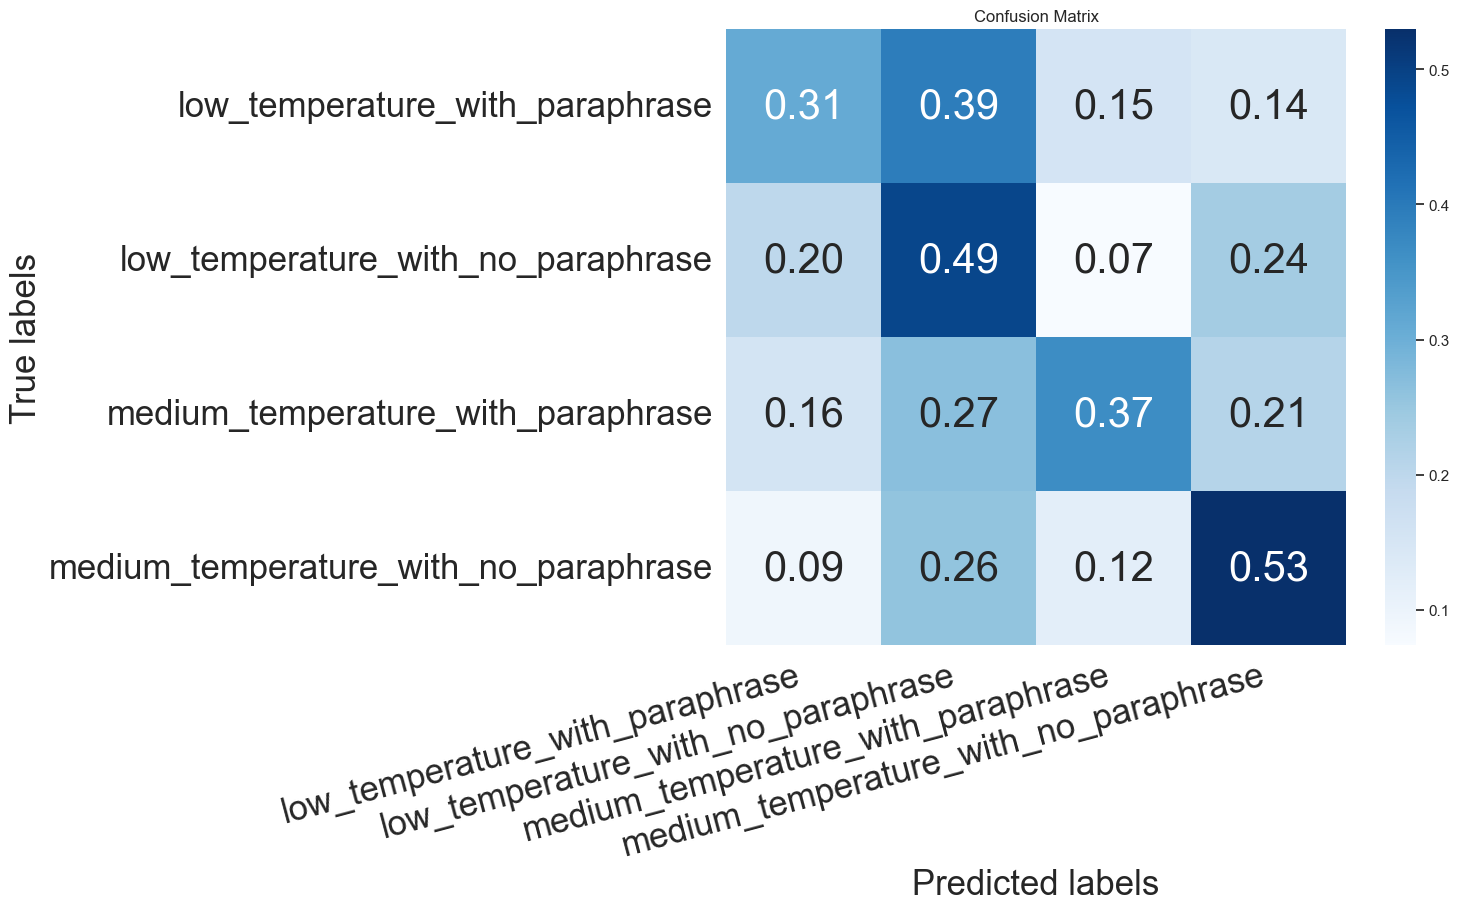

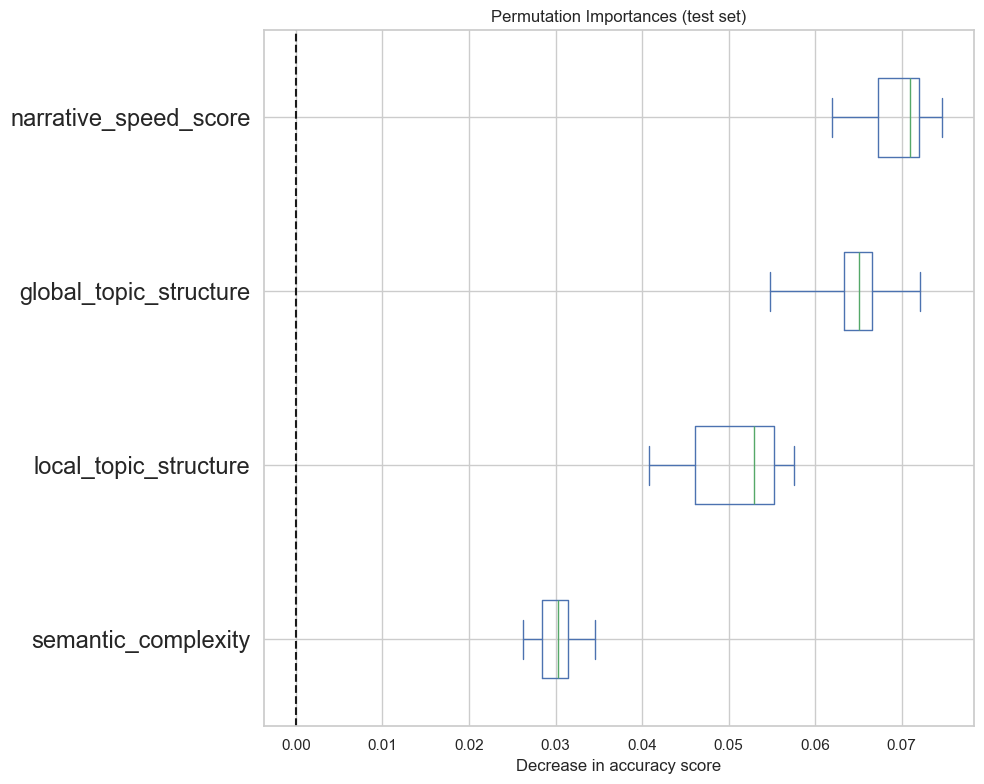

possible_misclassifications_paraphrase_only 4342
error_paraphrase_only 986
possible_misclassifications_temperature_only 4342
error_temperature_only 886
possible_misclassifications_fail_dissociate 2164
error_fail_dissociate 354


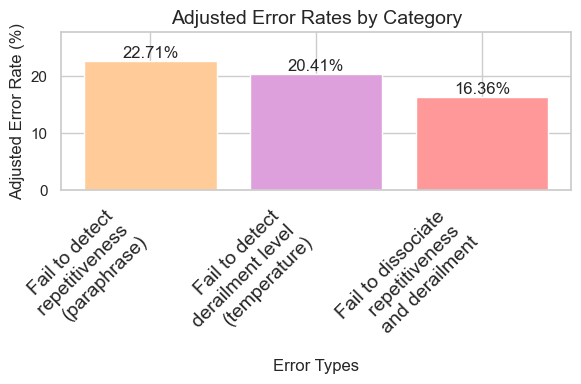

########################################
Training with cosine_mean_sim_metrics
Accuracy: 0.3643482266236757
F1 Score: 0.3622097659564328


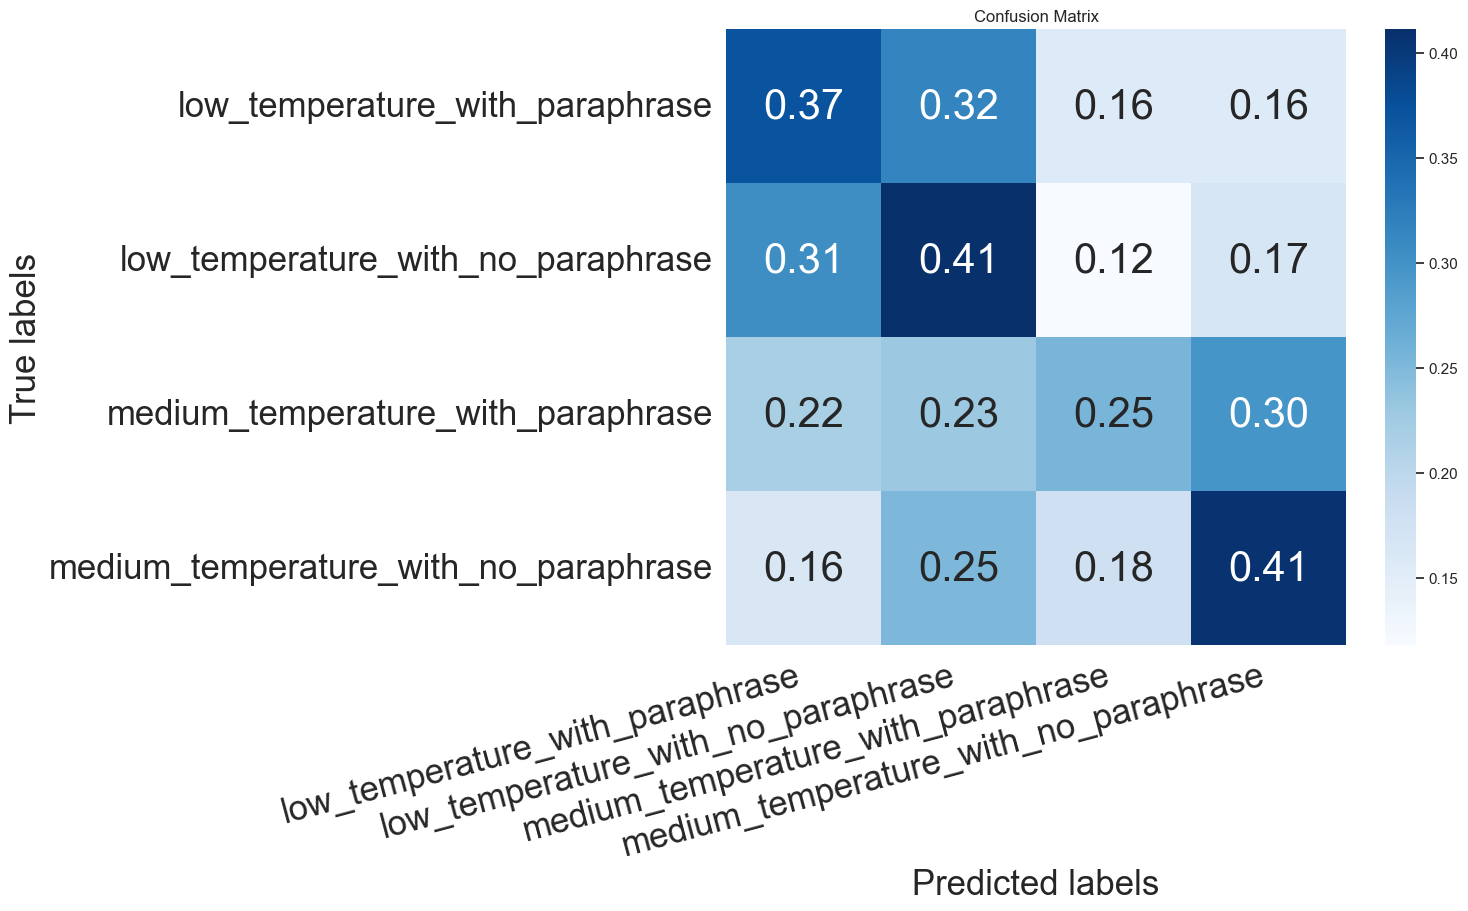

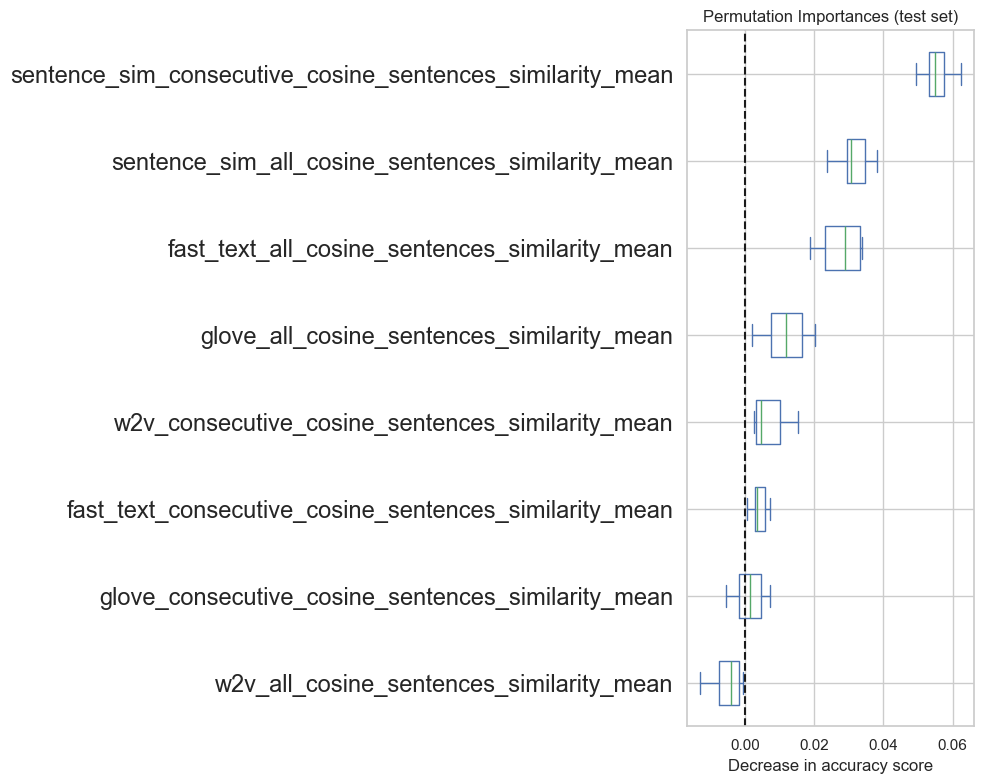

possible_misclassifications_paraphrase_only 4342
error_paraphrase_only 1184
possible_misclassifications_temperature_only 4342
error_temperature_only 860
possible_misclassifications_fail_dissociate 2164
error_fail_dissociate 368


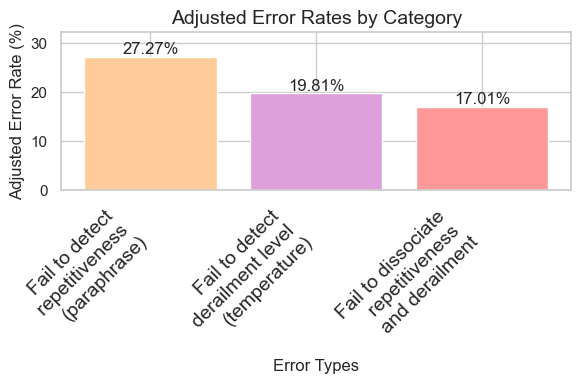

########################################
Training with wmd_mean_sim_metrics
Accuracy: 0.36250575771533855
F1 Score: 0.3509014775454499


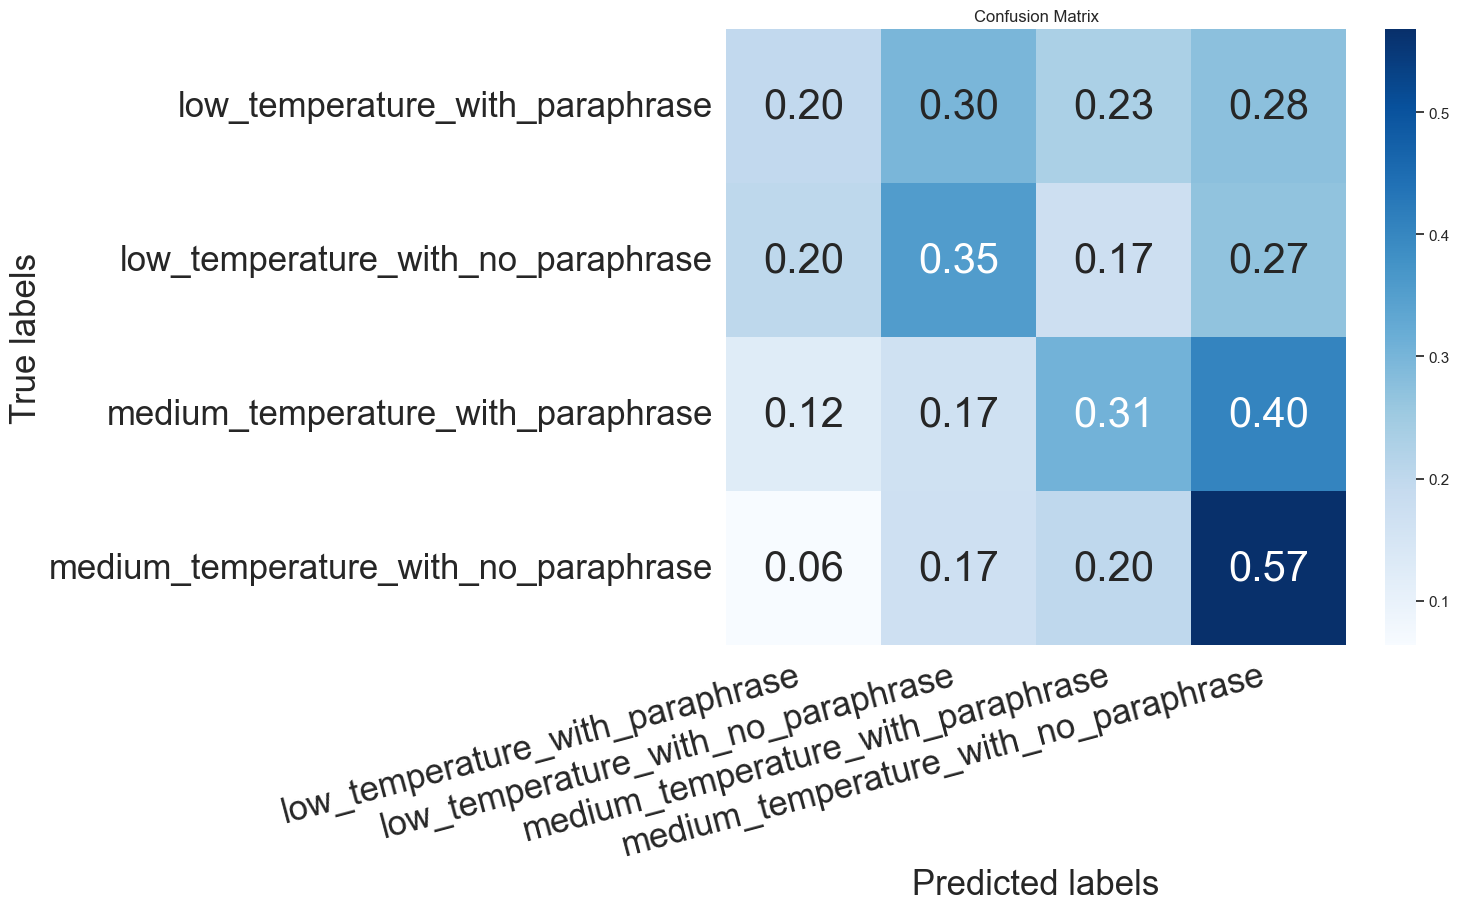

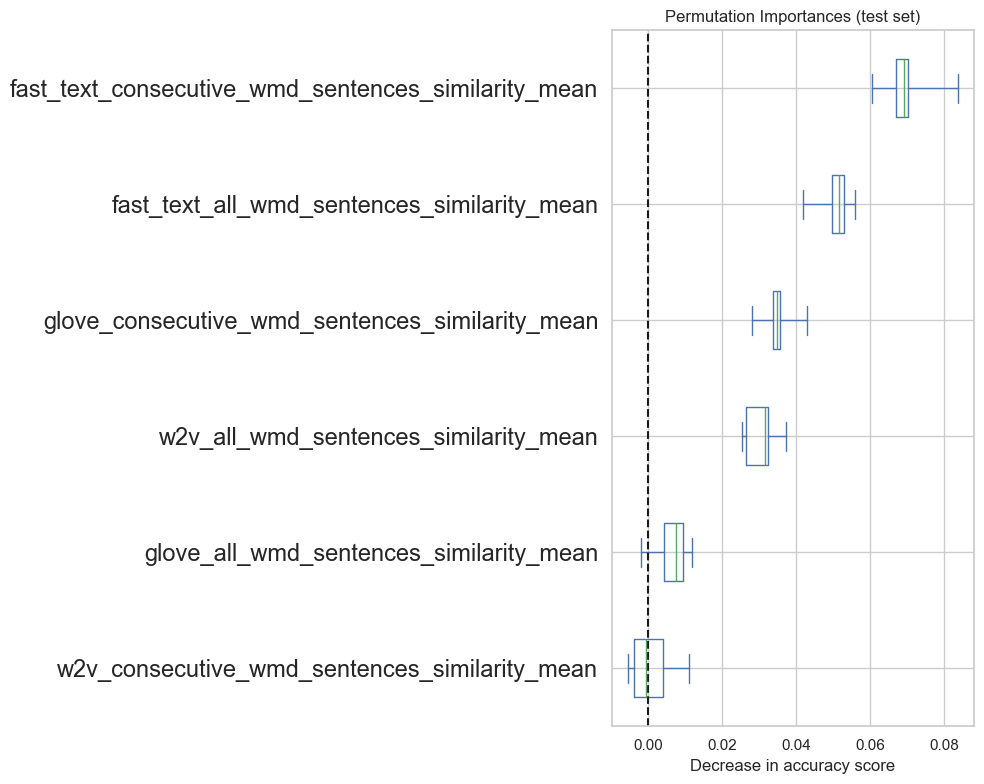

possible_misclassifications_paraphrase_only 4342
error_paraphrase_only 1176
possible_misclassifications_temperature_only 4342
error_temperature_only 868
possible_misclassifications_fail_dissociate 2164
error_fail_dissociate 368


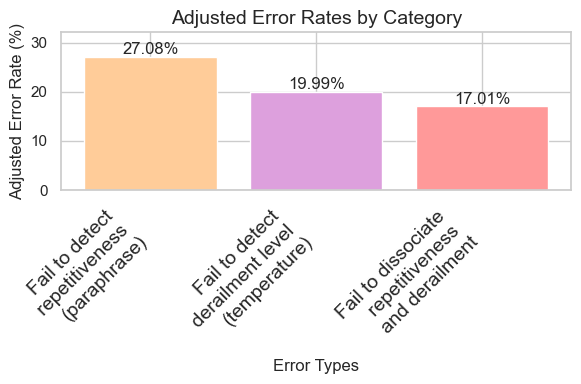

########################################
Training with mean_sim_metrics
Accuracy: 0.44081068631966835
F1 Score: 0.44026057407719943


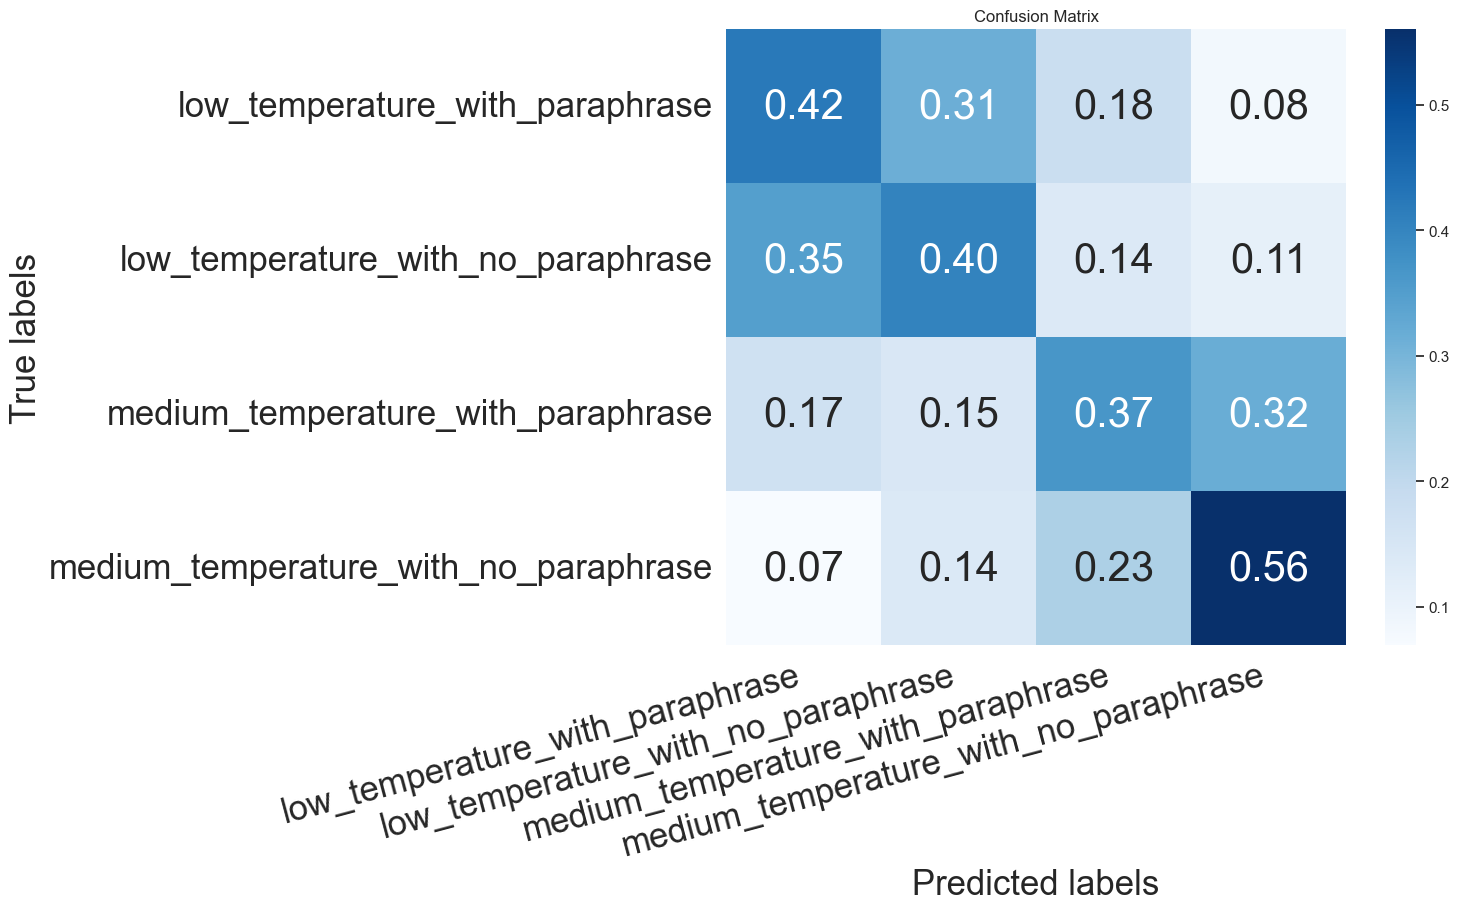

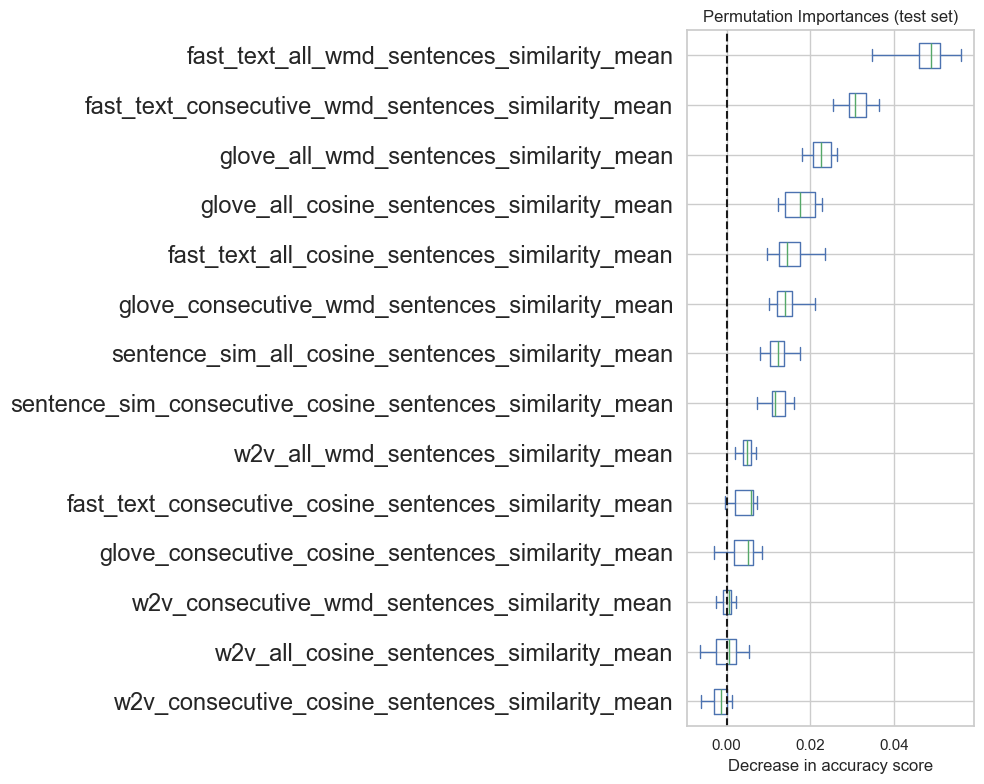

possible_misclassifications_paraphrase_only 4342
error_paraphrase_only 1311
possible_misclassifications_temperature_only 4342
error_temperature_only 647
possible_misclassifications_fail_dissociate 2164
error_fail_dissociate 305


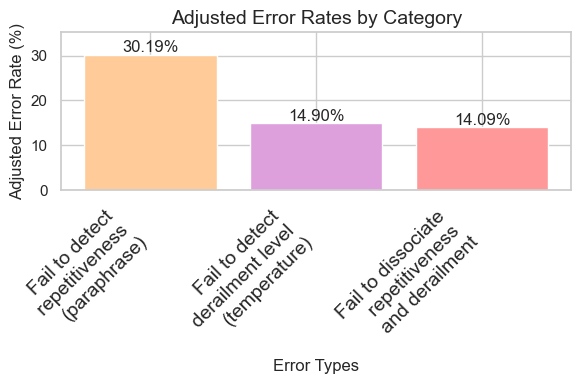

########################################
Training with sim_average
Accuracy: 0.35076001842468907
F1 Score: 0.3512056525553101


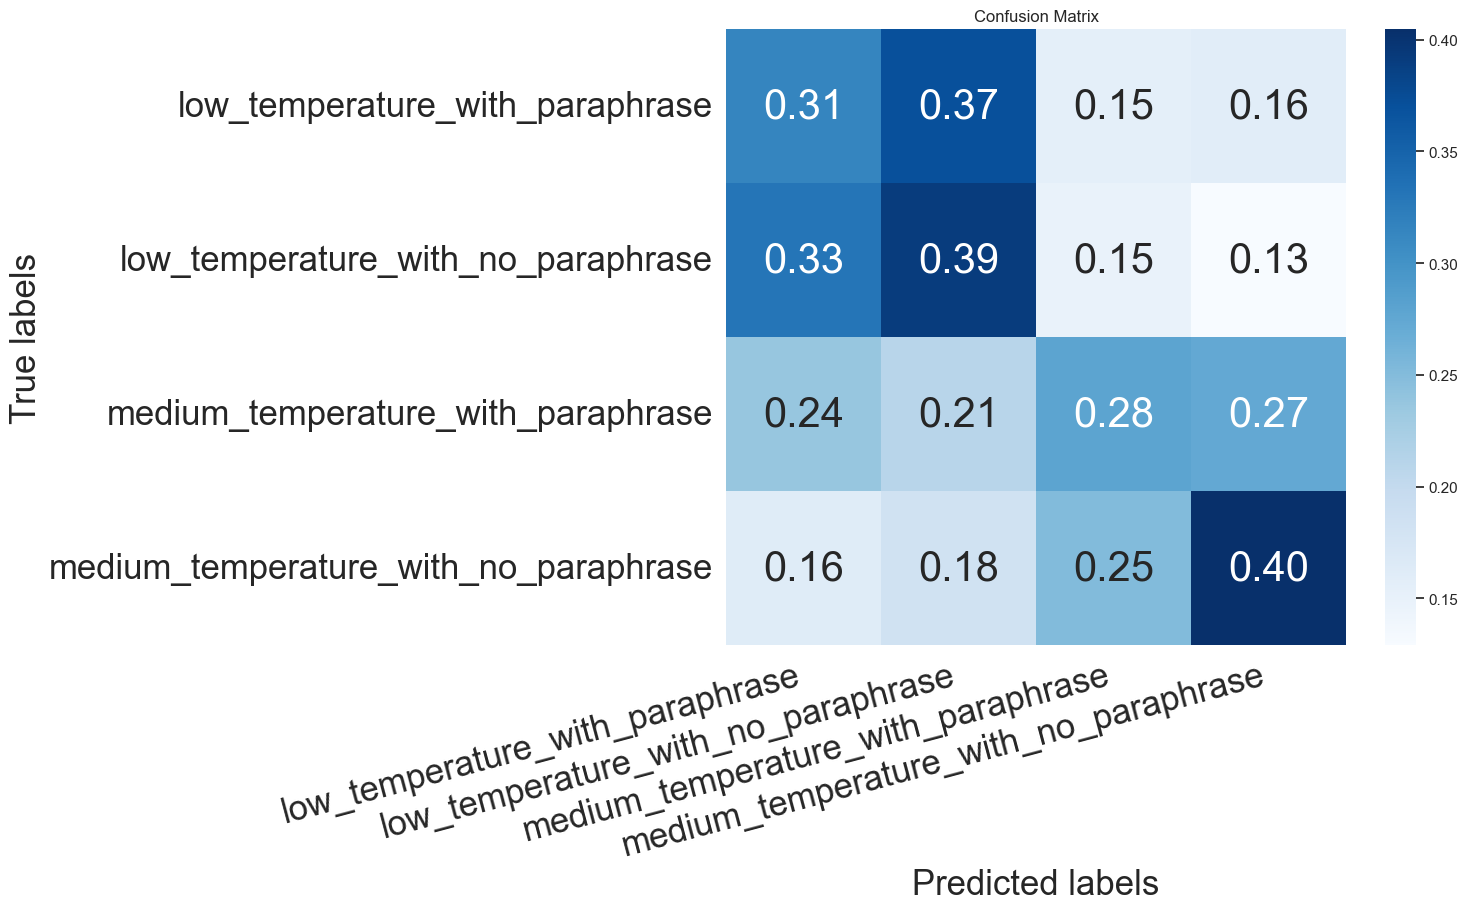

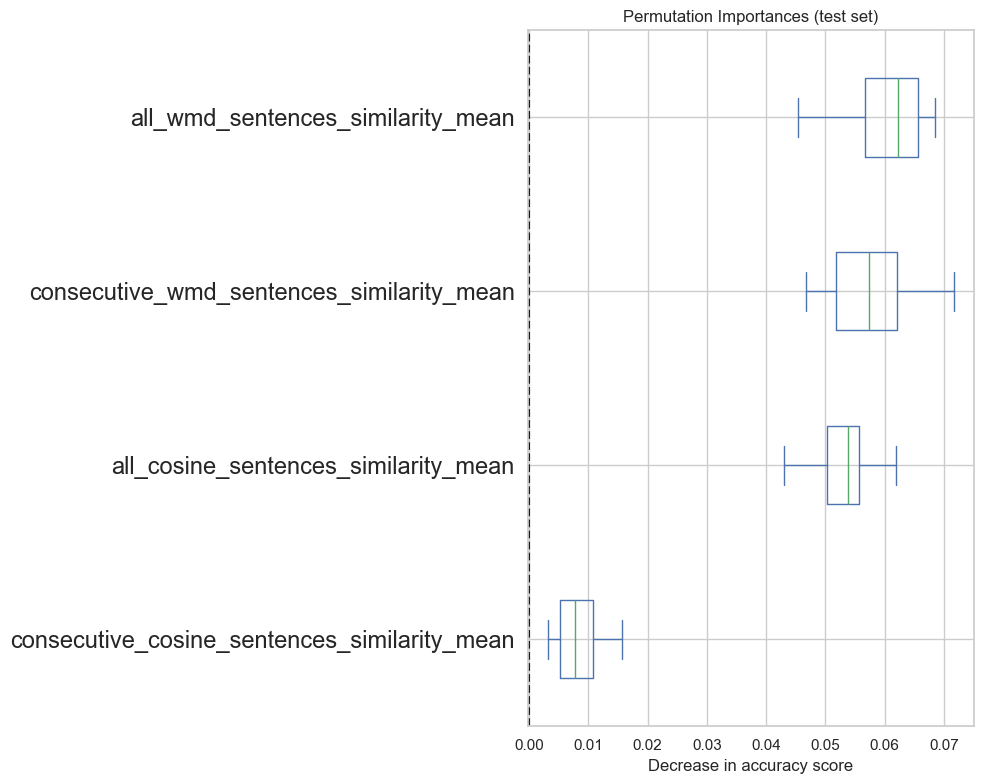

possible_misclassifications_paraphrase_only 4342
error_paraphrase_only 1327
possible_misclassifications_temperature_only 4342
error_temperature_only 758
possible_misclassifications_fail_dissociate 2164
error_fail_dissociate 384


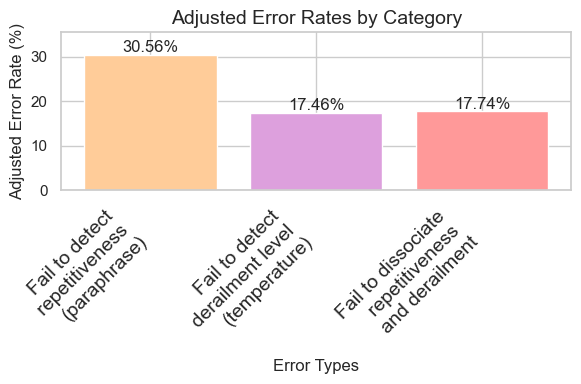

########################################
Training with all_features
Accuracy: 0.5147397512666974
F1 Score: 0.5140558304902924


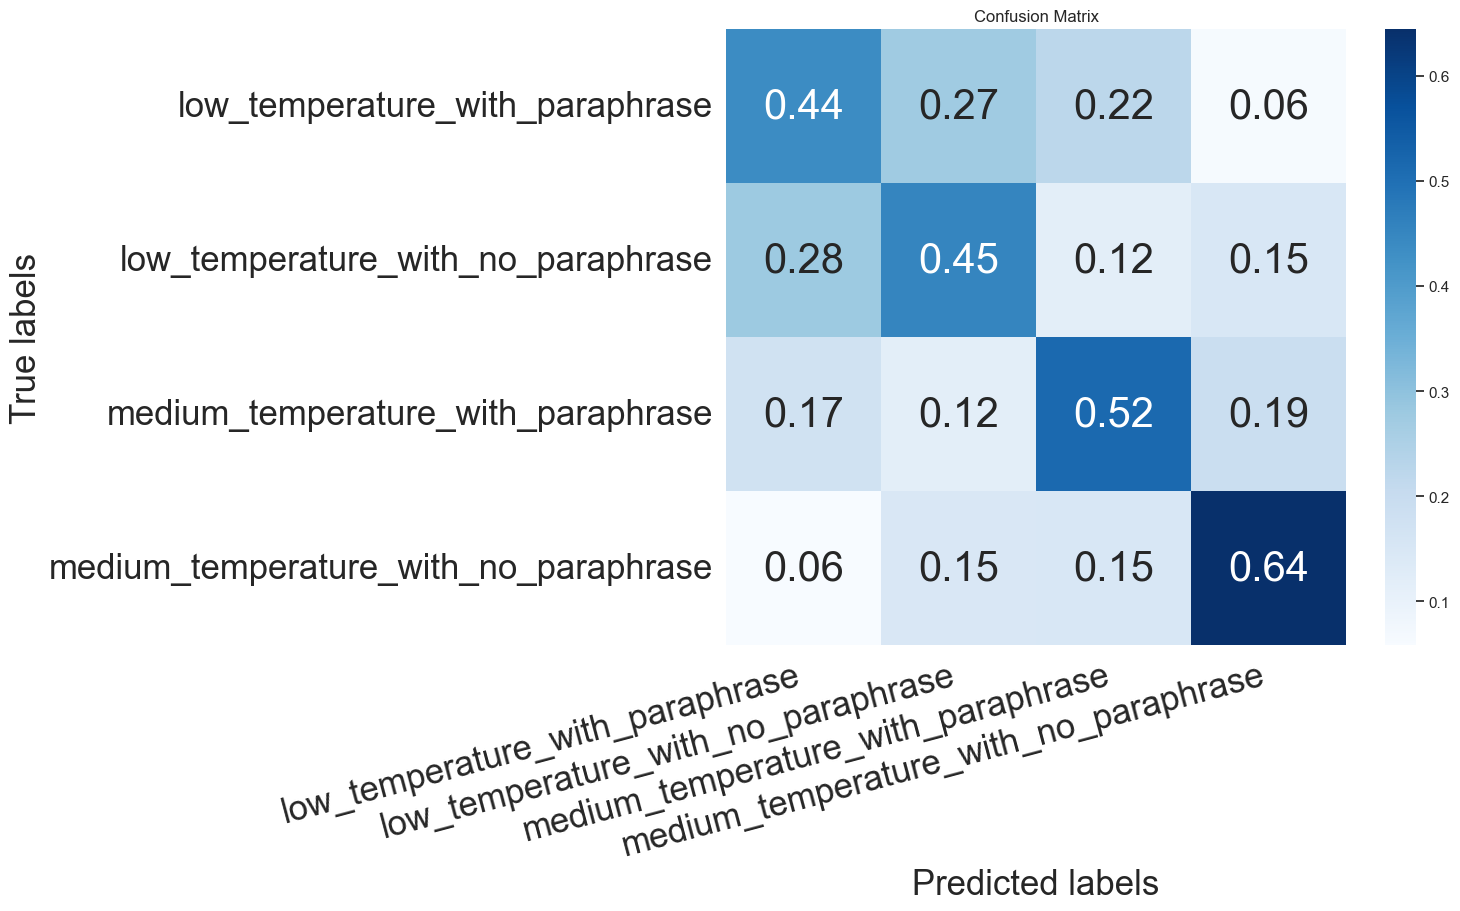

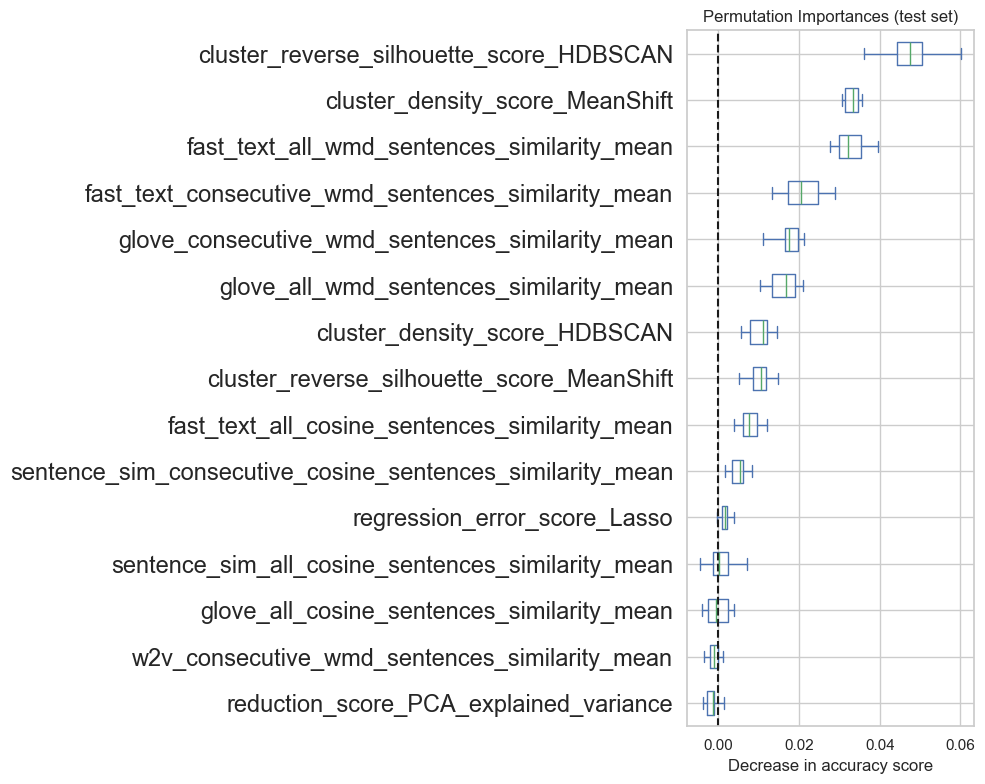

possible_misclassifications_paraphrase_only 4342
error_paraphrase_only 970
possible_misclassifications_temperature_only 4342
error_temperature_only 748
possible_misclassifications_fail_dissociate 2164
error_fail_dissociate 256


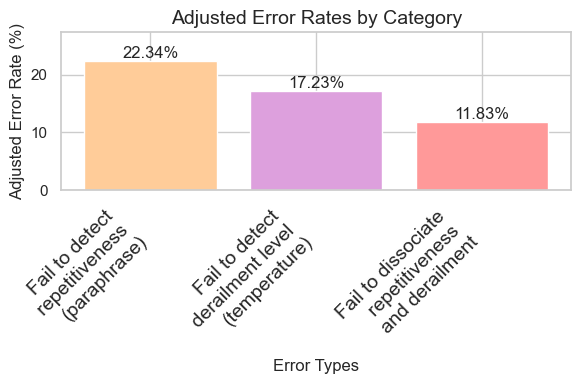

########################################
Training with all_average_features
Accuracy: 0.4659143251957623
F1 Score: 0.4587344504650421


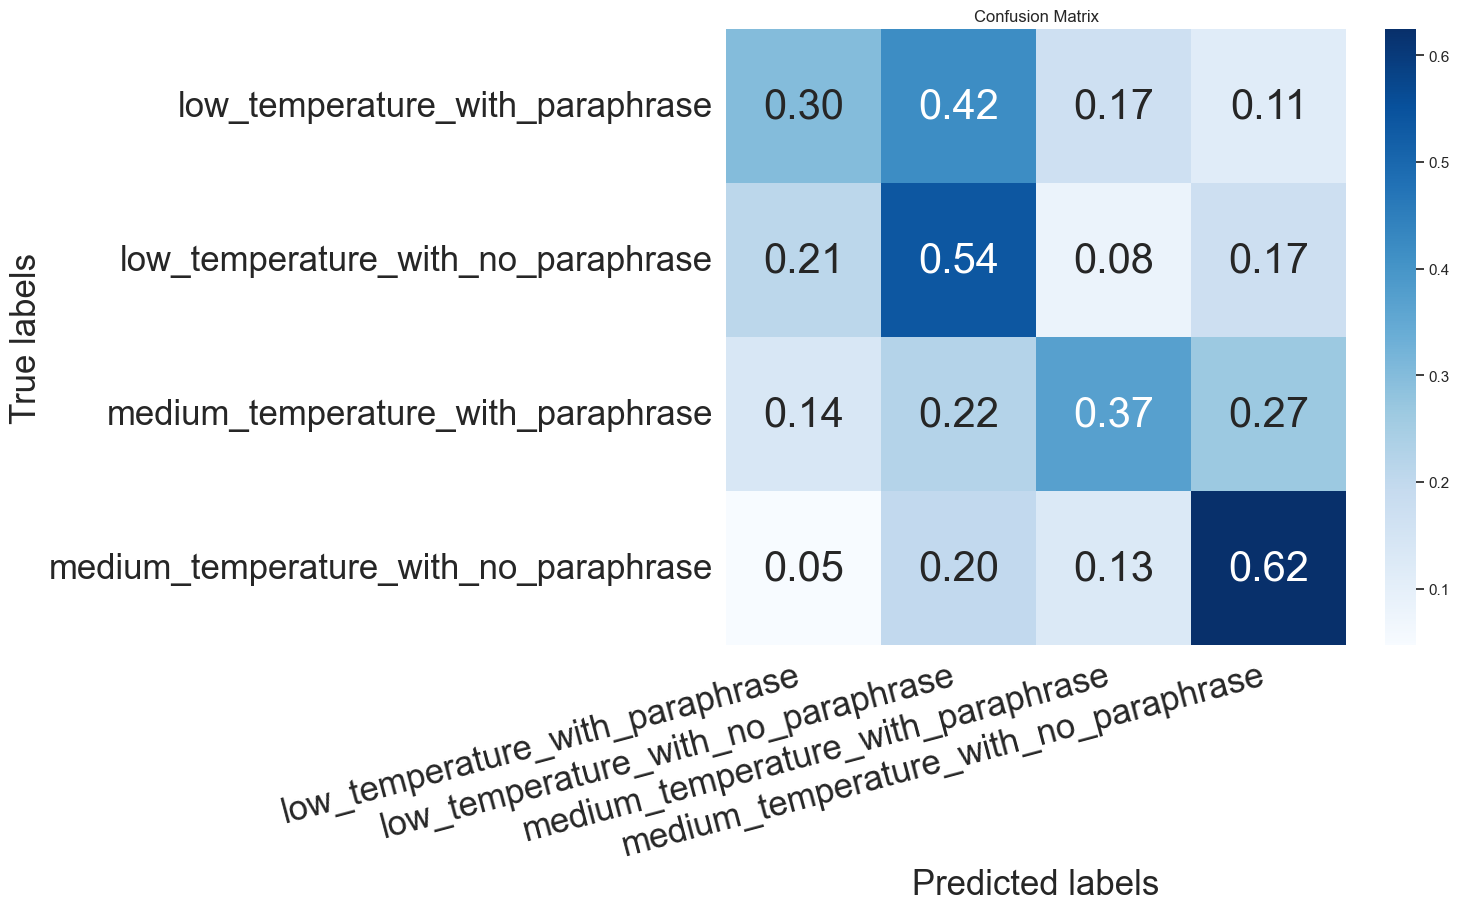

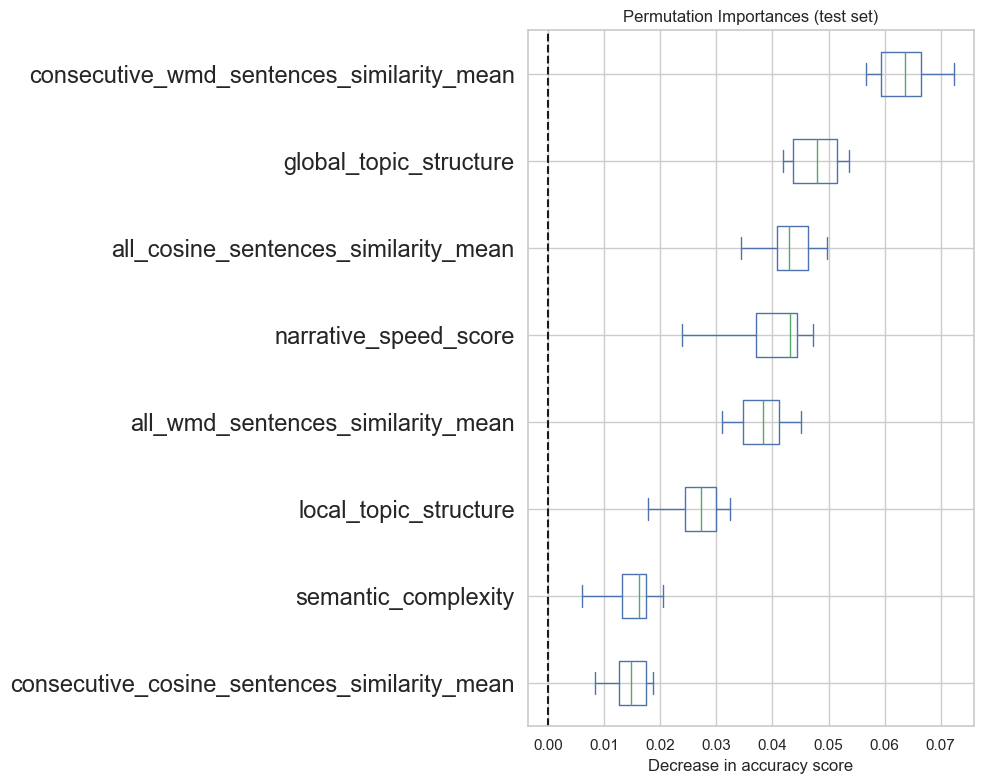

possible_misclassifications_paraphrase_only 4342
error_paraphrase_only 1091
possible_misclassifications_temperature_only 4342
error_temperature_only 738
possible_misclassifications_fail_dissociate 2164
error_fail_dissociate 320


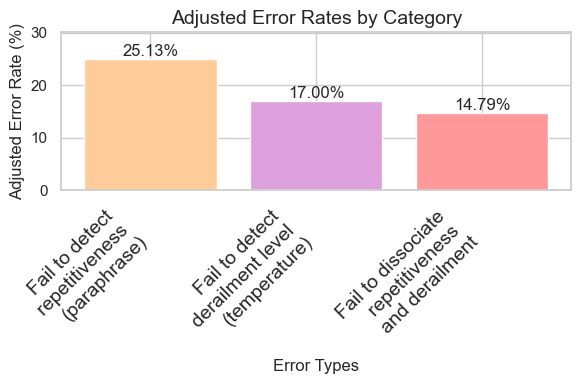

features_name  accuracy  f1_score
6             all_features   0.51474  0.514056
0         density_features  0.471211  0.469413
7     all_average_features  0.465914  0.458734
4         mean_sim_metrics  0.440811  0.440261
1          density_average  0.429526   0.42675
2  cosine_mean_sim_metrics  0.364348   0.36221
5              sim_average   0.35076  0.351206
3     wmd_mean_sim_metrics  0.362506  0.350901

In [ ]:
## One time results
plot = True
compute_context_auc  = False
error_type =True
df_results = train_and_evaluate_rf(features_dict,best_parameters_dict, dataset, y_name="cat_label", num_to_label = num_to_label, plot = plot, plot_error_type=error_type)
df_results.sort_values(by = "f1_score", ascending = False)
df_results[['features_name','accuracy','f1_score']].sort_values(by = "f1_score", ascending = False)

## II.  2 classes PSM filtered classification problem

###  a. Using mean cosine to build the matched PSM filtered classification problem

In [9]:
psm_dataset = filter_dataset(dataset,filter_name =  "psm", target_list=cosine_mean_sim_metrics)
y_name = "has_paraphrase"
psm_dataset['cat_label'] = psm_dataset[y_name]
psm_num_to_label = {0: "no_paraphrase", 1: "paraphrase"}
print(list(psm_num_to_label.keys()))
print(cosine_mean_sim_metrics)

Number of samples before and after PSM: 12539 -> 4731
[0, 1]
['w2v_consecutive_cosine_sentences_similarity_mean', 'w2v_all_cosine_sentences_similarity_mean', 'fast_text_consecutive_cosine_sentences_similarity_mean', 'fast_text_all_cosine_sentences_similarity_mean', 'glove_consecutive_cosine_sentences_similarity_mean', 'glove_all_cosine_sentences_similarity_mean', 'sentence_sim_consecutive_cosine_sentences_similarity_mean', 'sentence_sim_all_cosine_sentences_similarity_mean']


########################################
Training with density_features
Accuracy: 0.6645885286783042
F1 Score: 0.6632938147348951


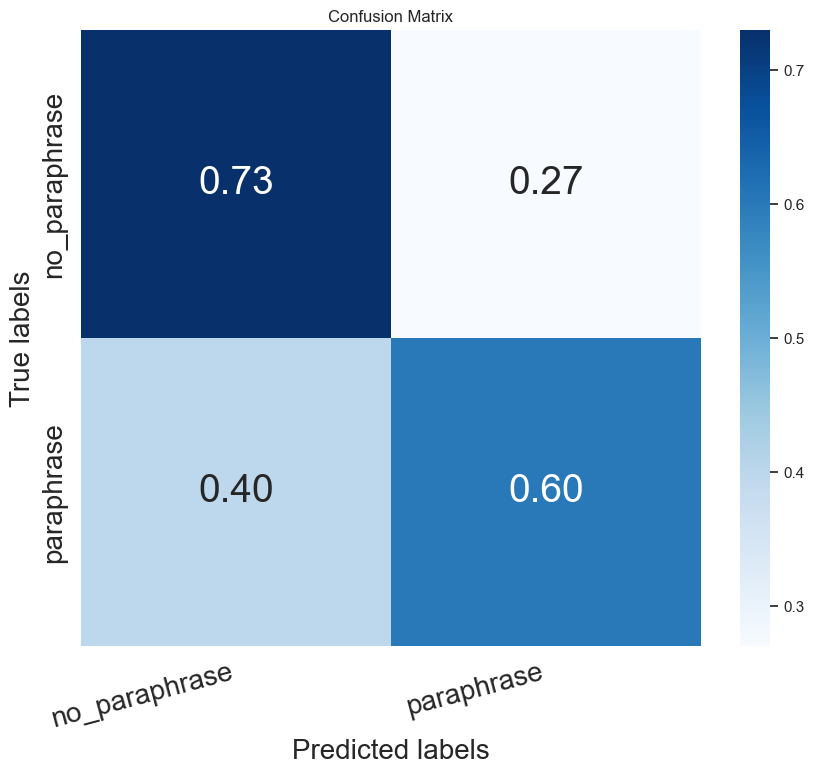

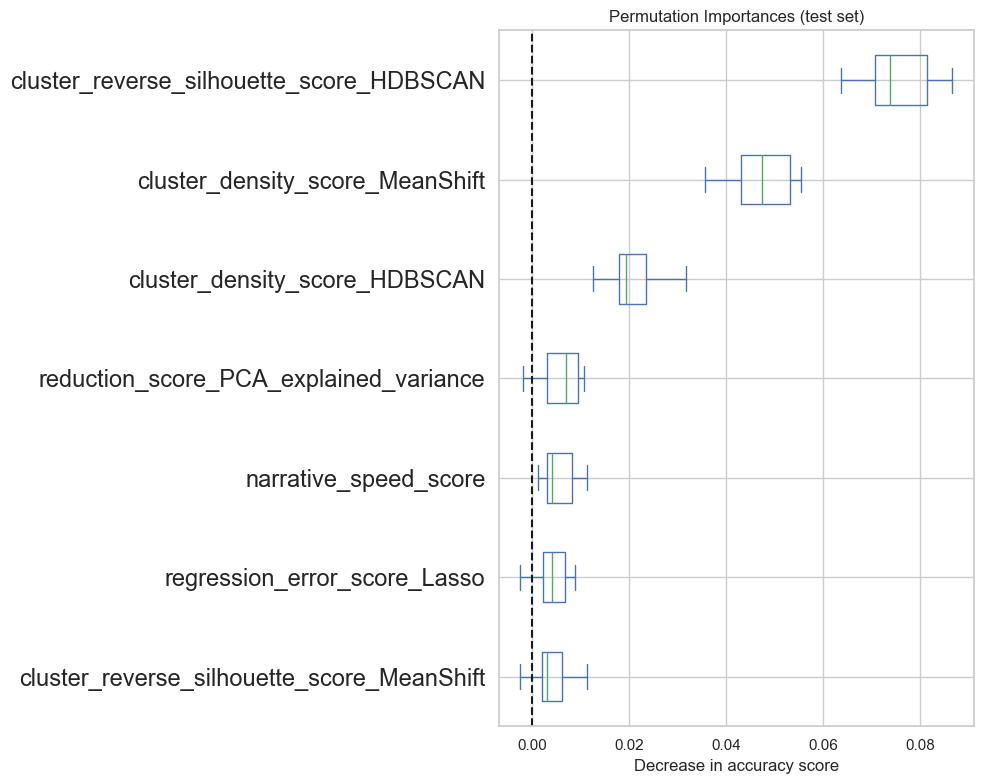

########################################
Training with cosine_mean_sim_metrics
Accuracy: 0.5261845386533666
F1 Score: 0.5237095962214966


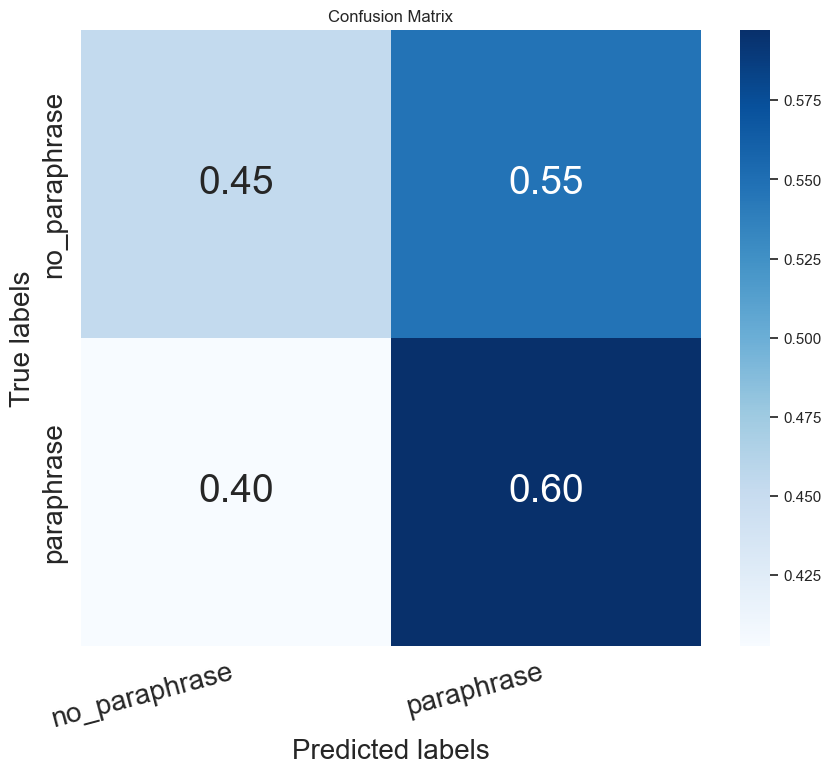

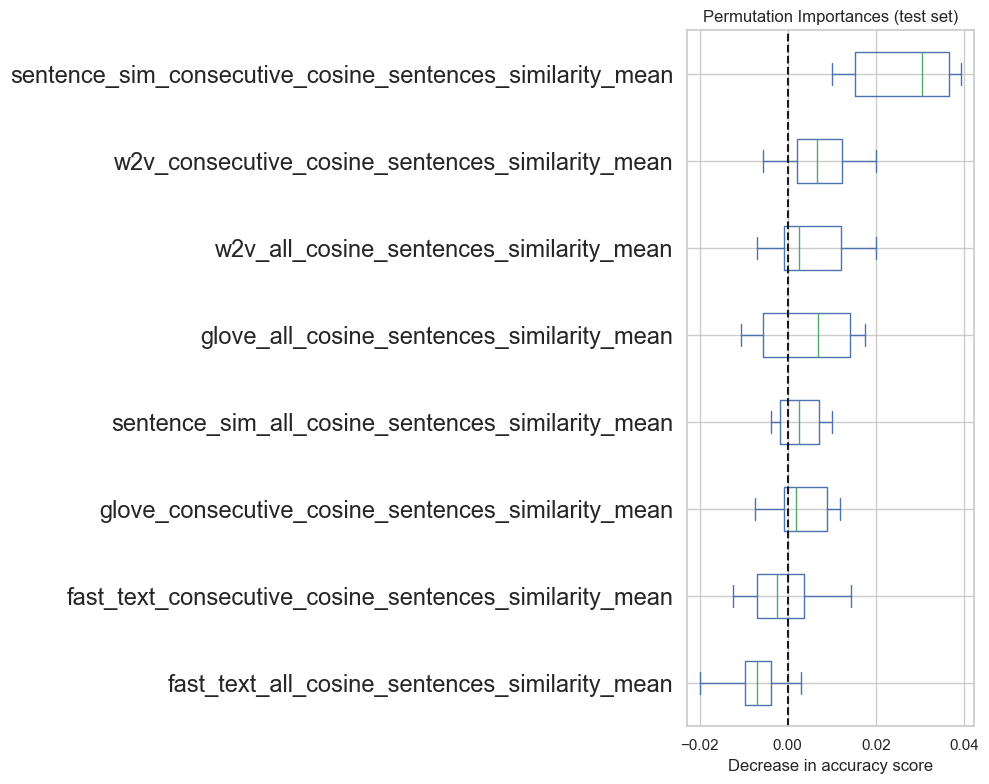

########################################
Training with wmd_mean_sim_metrics
Accuracy: 0.5903990024937655
F1 Score: 0.579600487752754


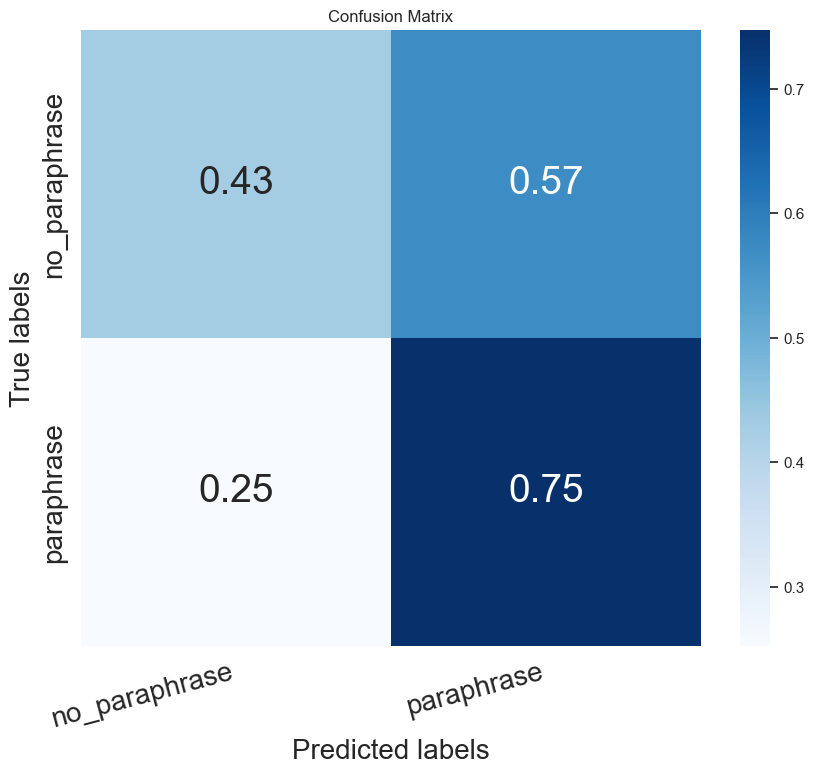

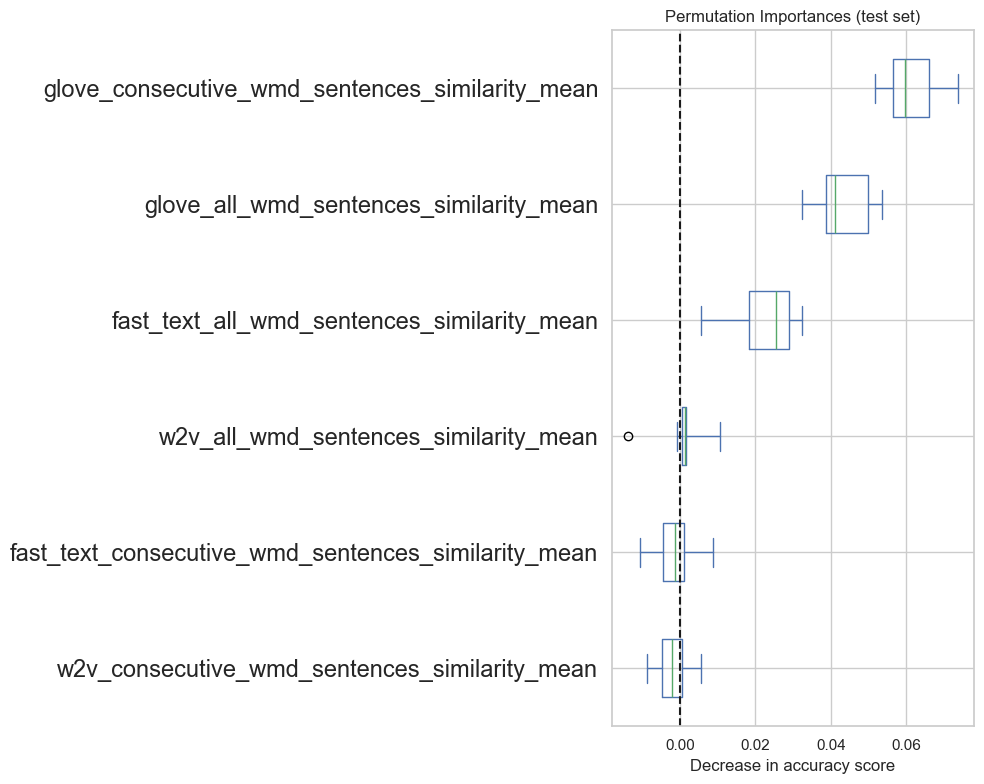

########################################
Training with density_without_narrative_speed
Accuracy: 0.6583541147132169
F1 Score: 0.6574284528304687


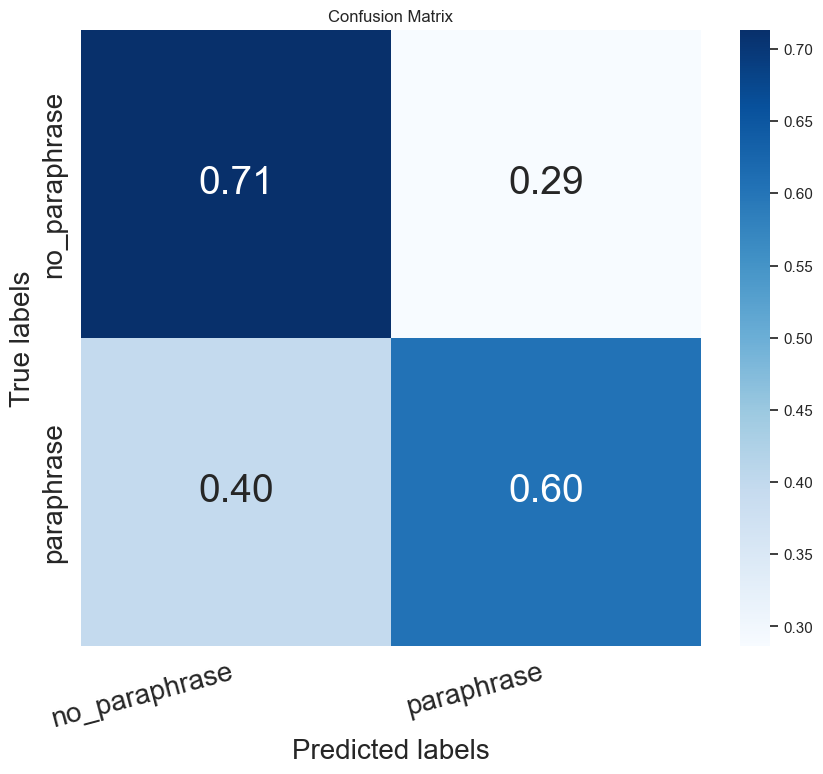

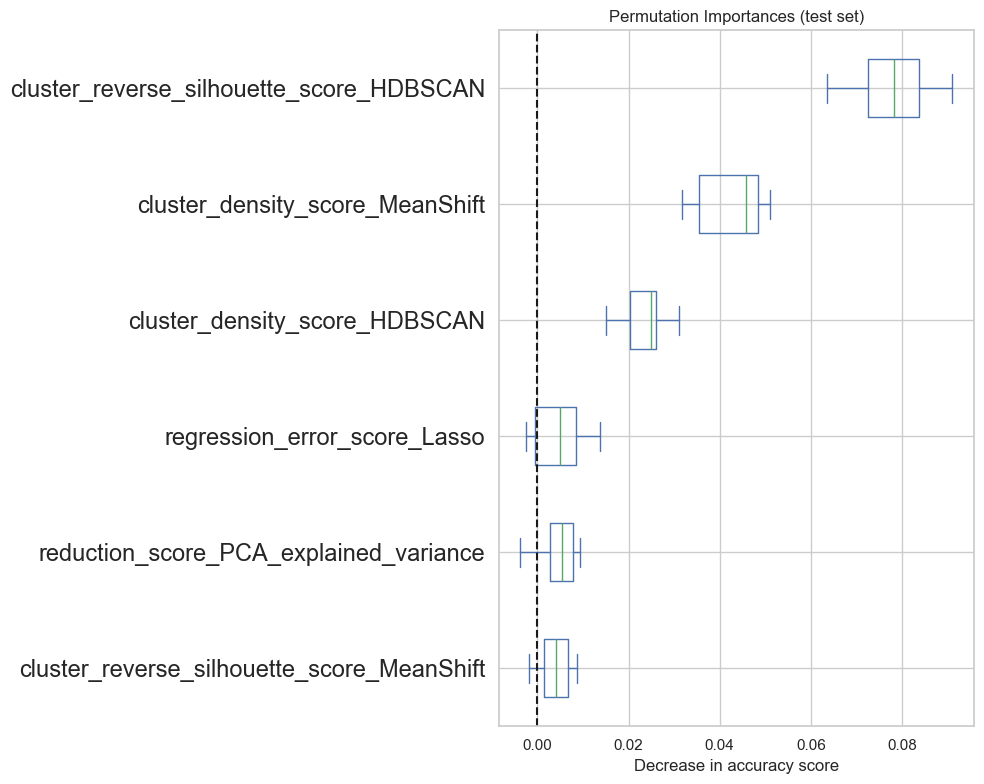

In [10]:
features_dict_short = {
    "density_features": density,
    "cosine_mean_sim_metrics": cosine_mean_sim_metrics,
    "wmd_mean_sim_metrics": wmd_mean_sim_metrics,
    "density_without_narrative_speed": [elt for elt in density if elt != "narrative_speed_score"],}
error_type = False
df_results = train_and_evaluate_rf(features_dict_short,best_parameters_dict, psm_dataset, y_name="cat_label", num_to_label = psm_num_to_label,plot_error_type=error_type)

### b. Using Density to build the matched PSM filtered classification problem

In [11]:
psm_density_dataset = filter_dataset(dataset,filter_name =  "psm", target_list= [elt for elt in density if elt !="narrative_speed_score"])
y_name = "has_paraphrase"
psm_density_dataset['cat_label'] = psm_density_dataset[y_name]
psm_num_to_label = {0: "no_paraphrase", 1: "paraphrase"}
print(list(psm_num_to_label.keys()))
print(density)

Number of samples before and after PSM: 12539 -> 4307
[0, 1]
['cluster_density_score_MeanShift', 'cluster_reverse_silhouette_score_MeanShift', 'cluster_density_score_HDBSCAN', 'cluster_reverse_silhouette_score_HDBSCAN', 'reduction_score_PCA_explained_variance', 'regression_error_score_Lasso', 'narrative_speed_score']


########################################
Training with density_features
Accuracy: 0.6202277294038848
F1 Score: 0.6201101237739599


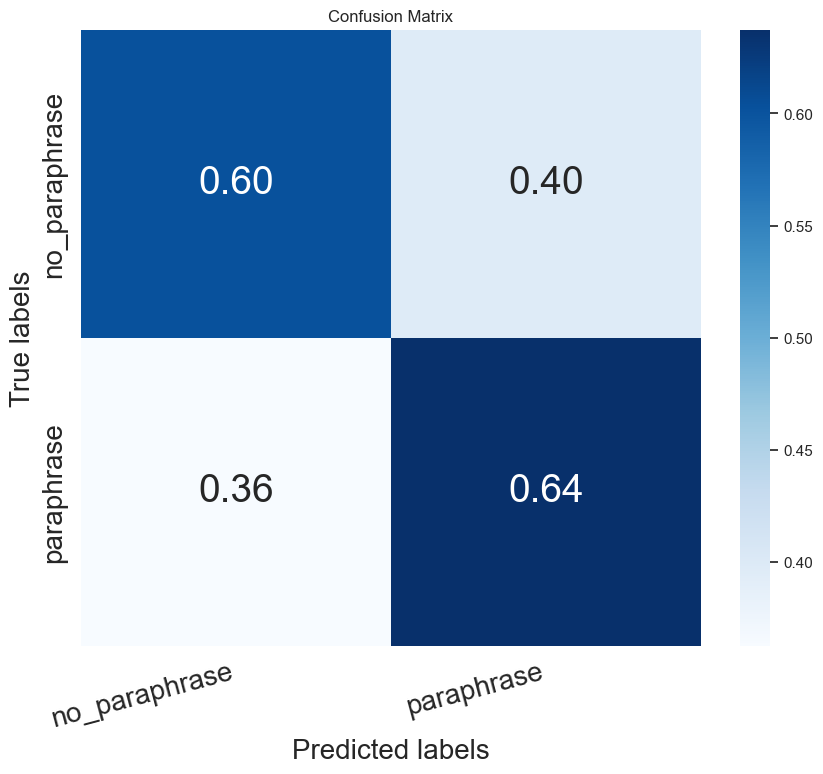

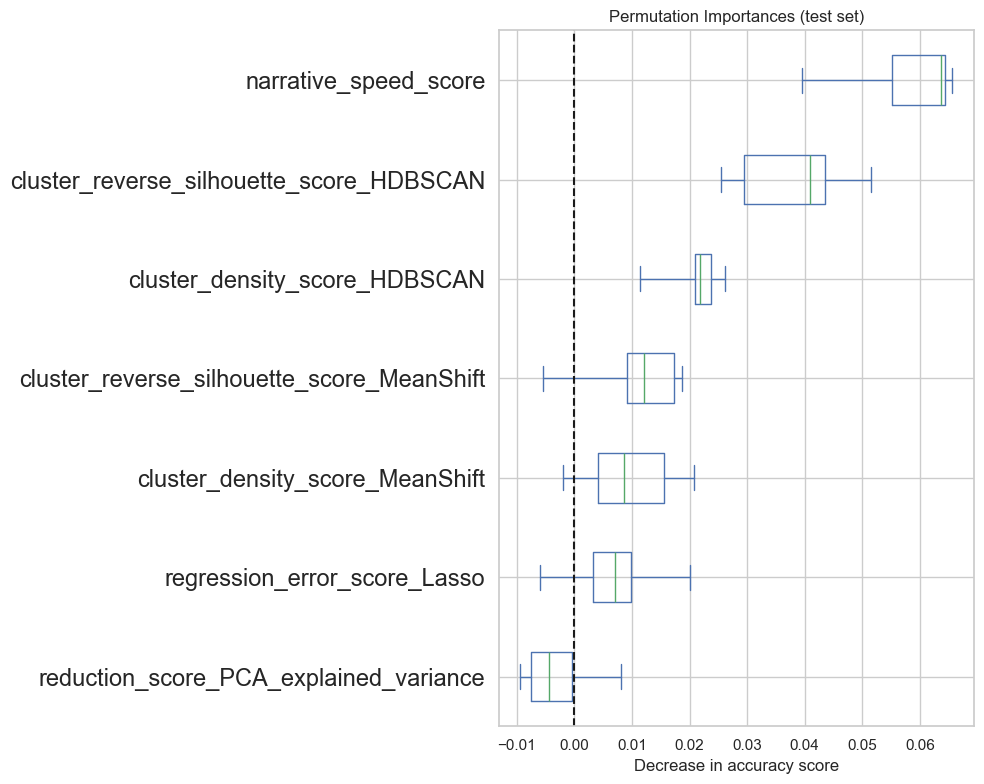

########################################
Training with cosine_mean_sim_metrics
Accuracy: 0.6115204286671132
F1 Score: 0.6111288865524664


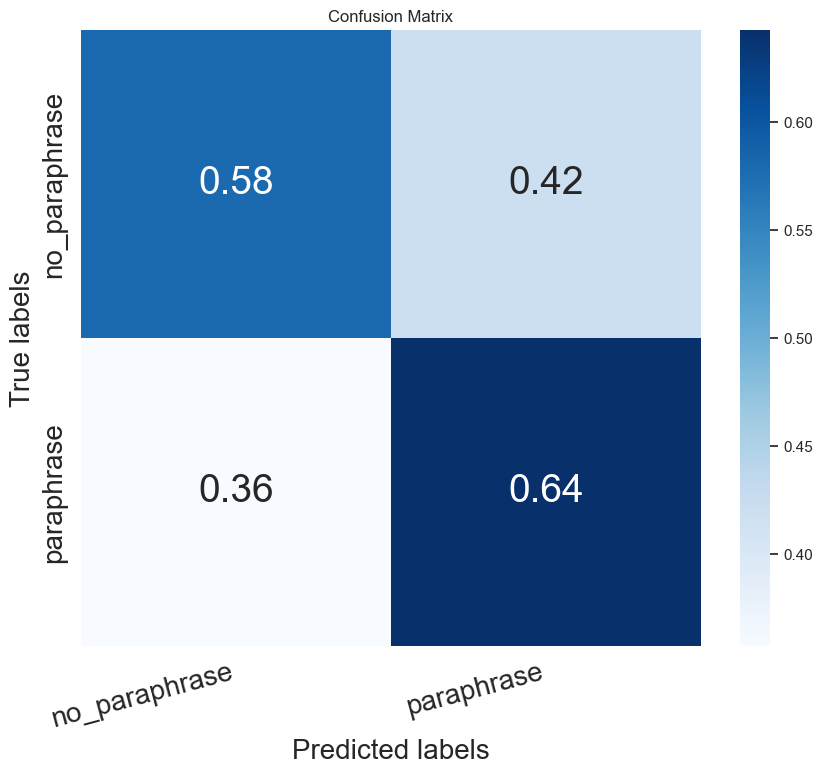

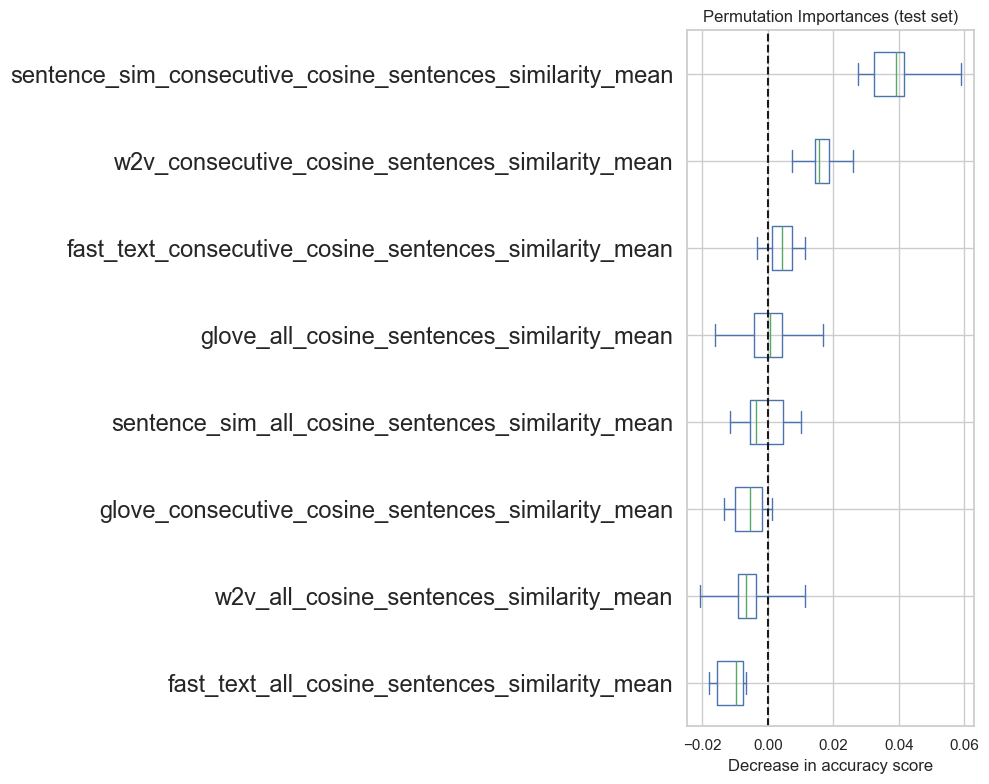

########################################
Training with wmd_mean_sim_metrics
Accuracy: 0.6155391828533154
F1 Score: 0.6124412734692635


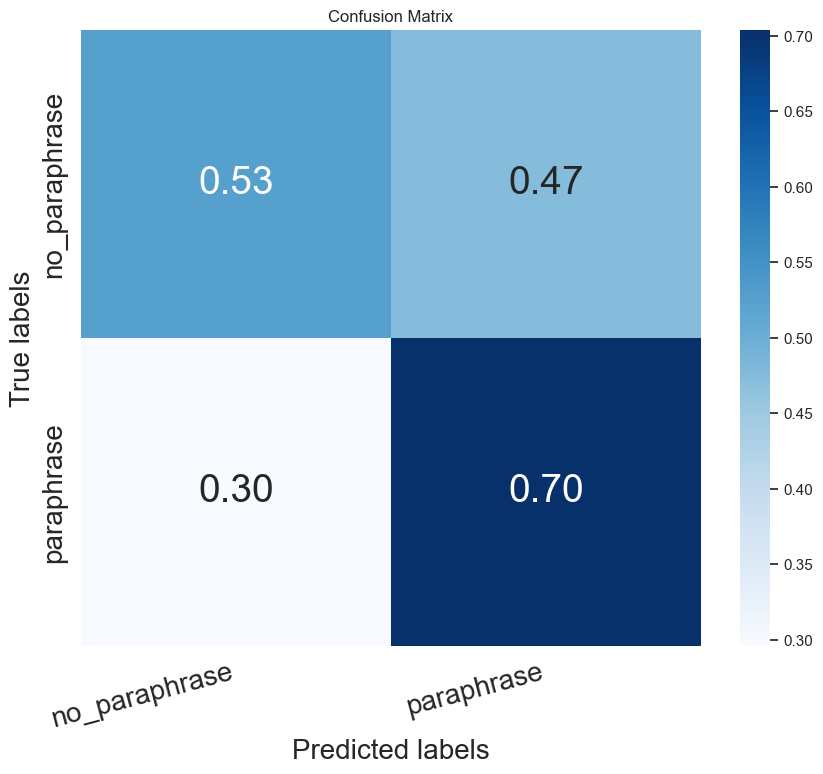

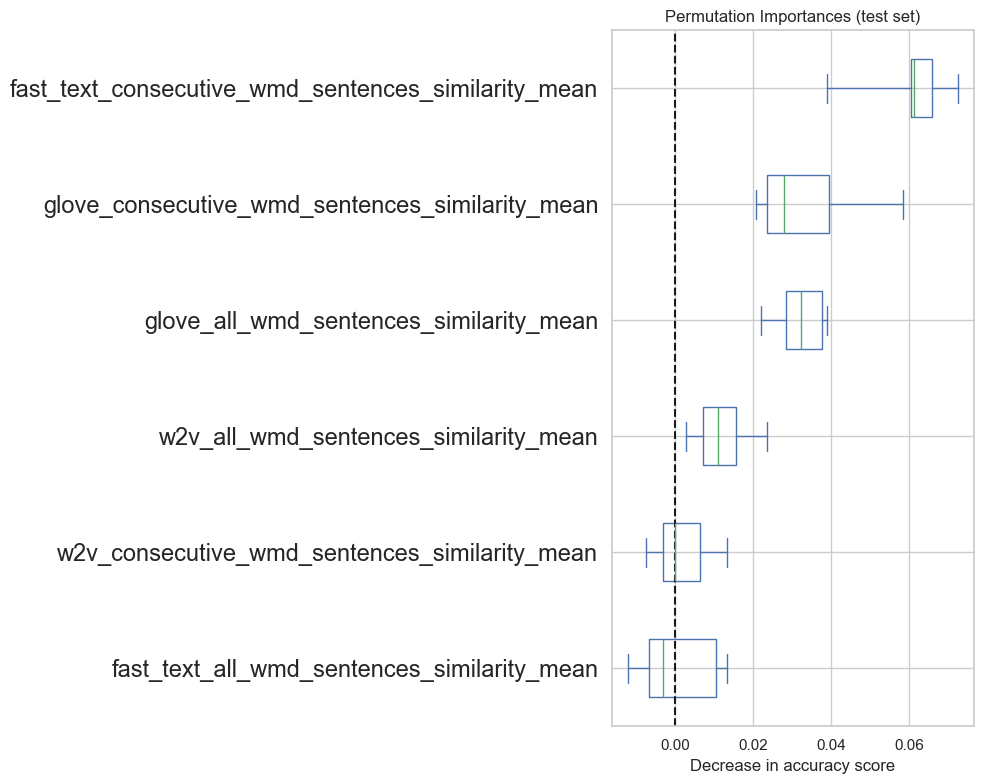

########################################
Training with density_without_narrative_speed
Accuracy: 0.6001339584728734
F1 Score: 0.5995211865252966


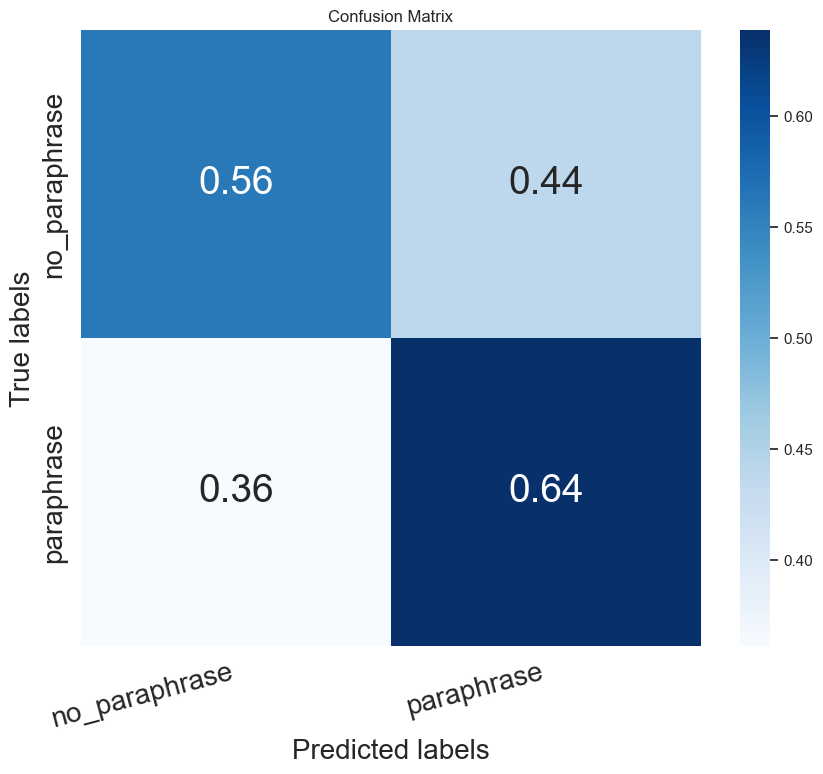

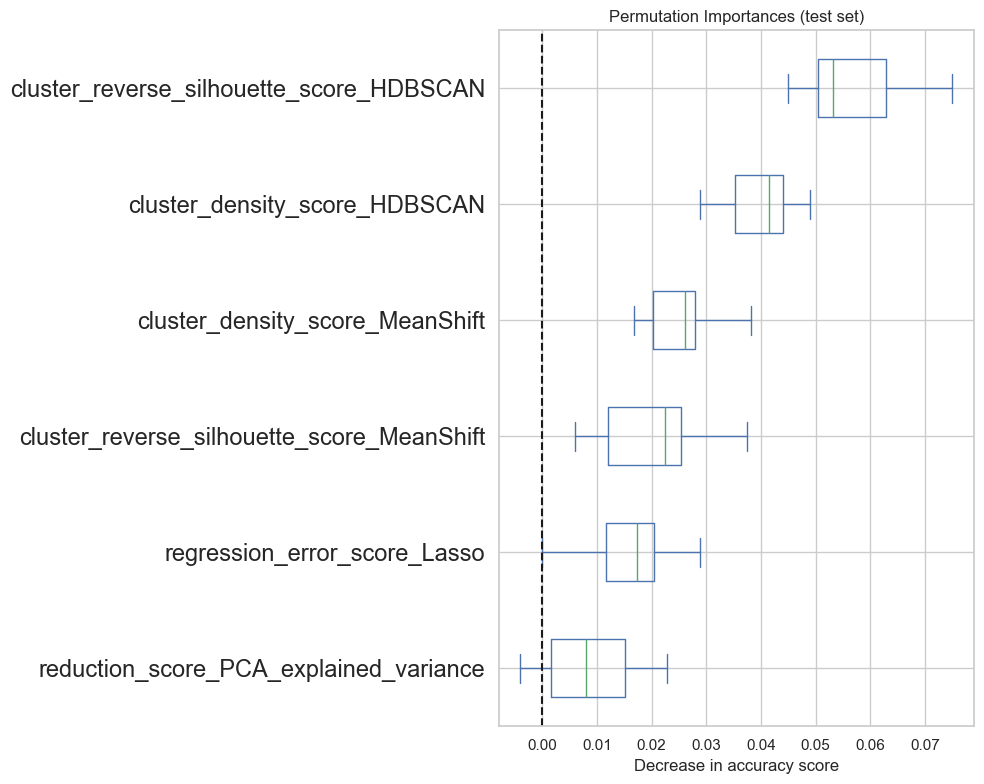

In [12]:
df_results = train_and_evaluate_rf(features_dict_short,best_parameters_dict, psm_density_dataset, y_name="cat_label", num_to_label = psm_num_to_label, plot_error_type=error_type)

## Experiments (until the end of the notebook)

index  matched_ID
0     15482        4298
1     15069        9664
2     15686        8354
3      5290        2311
4     11414        4580
...     ...         ...
3582  16144        9808
3583  11184        3818
3584  10584        3587
3585  11320        2629
3586  11621        9967

[3587 rows x 2 columns]

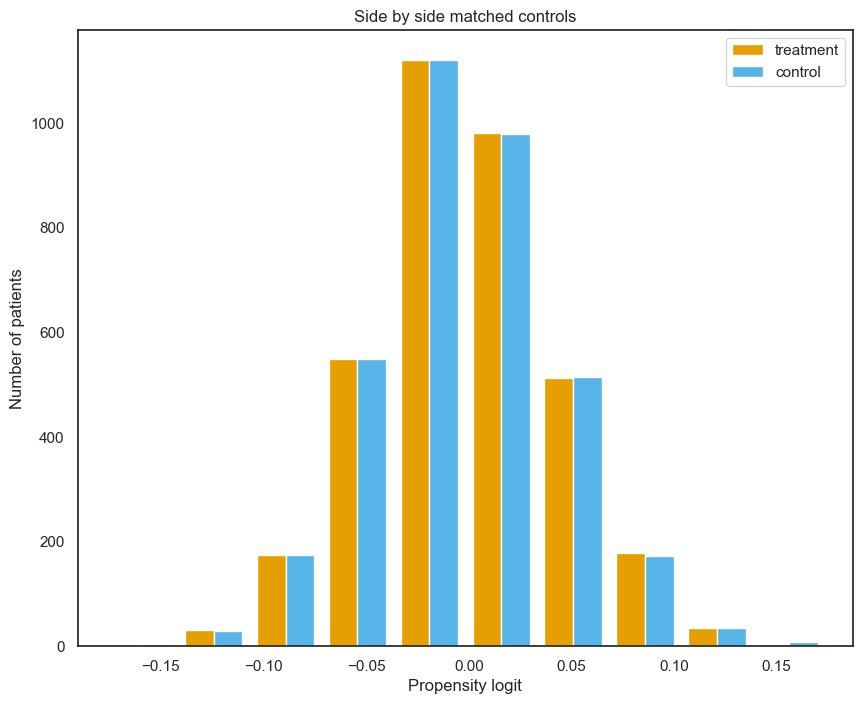

In [35]:
def make_treatment_1(x):
    if x in ['low_temperature_with_no_paraphrase']:
        return 0
    elif x in ['high_temperature_with_paraphrase', 'medium_temperature_with_paraphrase']:
        return 1
    else :  return -1

plot = True
test_dataset = dataset.copy()
test_dataset['index'] = test_dataset.index
test_dataset['treatment_1'] = test_dataset['combined_label'].apply(make_treatment_1)
treatment_name = 'treatment_1'
target_list= ['w2v_all_wmd_sentences_similarity_mean']

dataset = dataset[dataset[treatment_name ]!= -1]
df_to_match = dataset[target_list + [treatment_name,'index']]

psm = PsmPy(df_to_match, treatment=treatment_name, indx="index",exclude = [])
psm.logistic_ps(balance = True)
psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=None)
index_to_keep = psm.df_matched['index'].tolist()
if plot:
        psm.plot_match(Title='Side by side matched controls', Ylabel='Number of patients', Xlabel= 'Propensity logit', names = ['treatment', 'control'], save=True)
psm.matched_ids


In [37]:
from scipy.spatial import distance
import numpy as np
from scipy.spatial.distance import cdist

target_list = density
covariates = dataset[target_list]
treated = dataset[dataset[treatment_name] == 1]
control = dataset[dataset[treatment_name] == 0]

# Calculate Mahalanobis distance
cov_matrix = np.cov(covariates, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Get Mahalanobis distances between treated and control
distances = cdist(treated[target_list], control[target_list], 'mahalanobis', VI=inv_cov_matrix)

# Find closest matches
min_distances = distances.argmin(axis=1)
matched_indices = control.iloc[min_distances].index

# Subset the data to include only matched samples
matched_data = pd.concat([treated, control.loc[matched_indices]])


########################################
Training with density_features
Accuracy: 1.0
F1 Score: 1.0


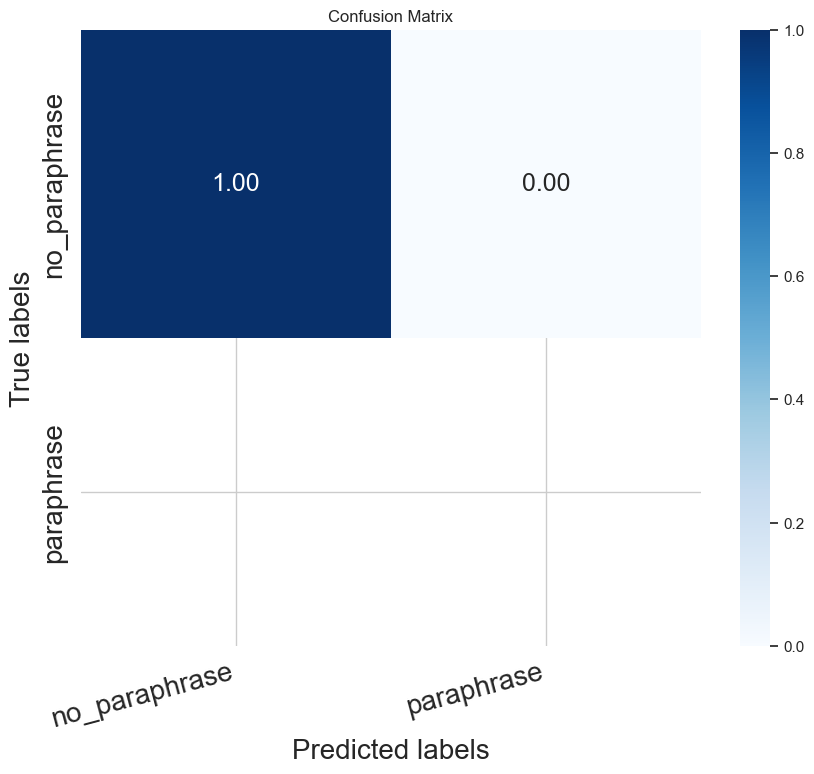

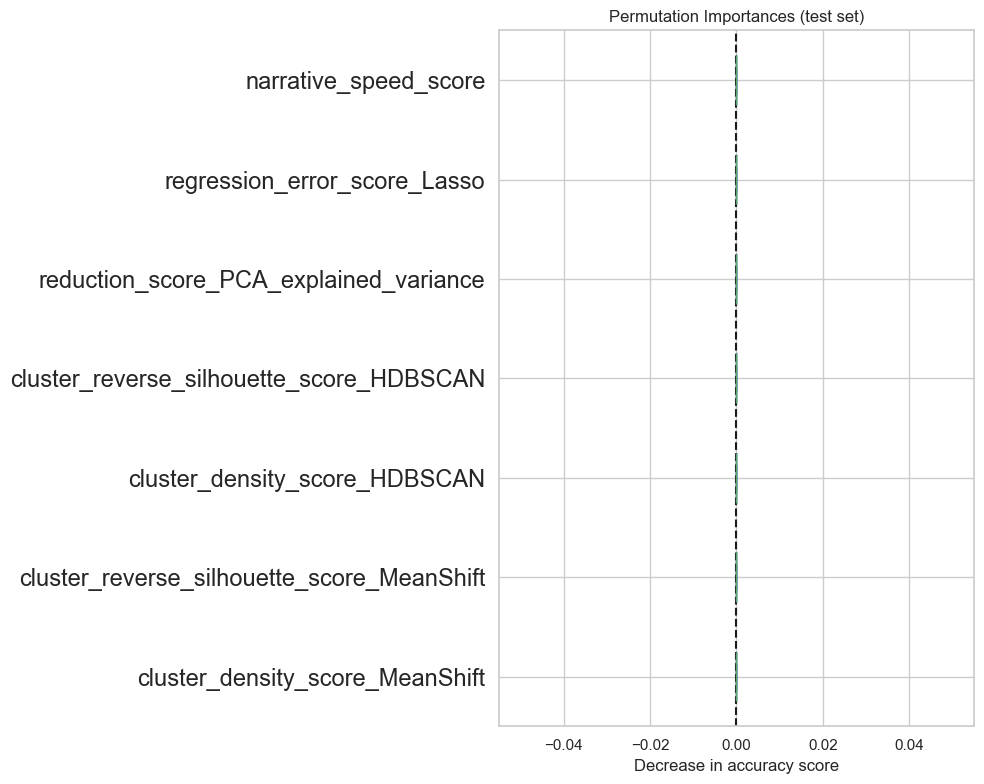

########################################
Training with cosine_mean_sim_metrics
Accuracy: 1.0
F1 Score: 1.0


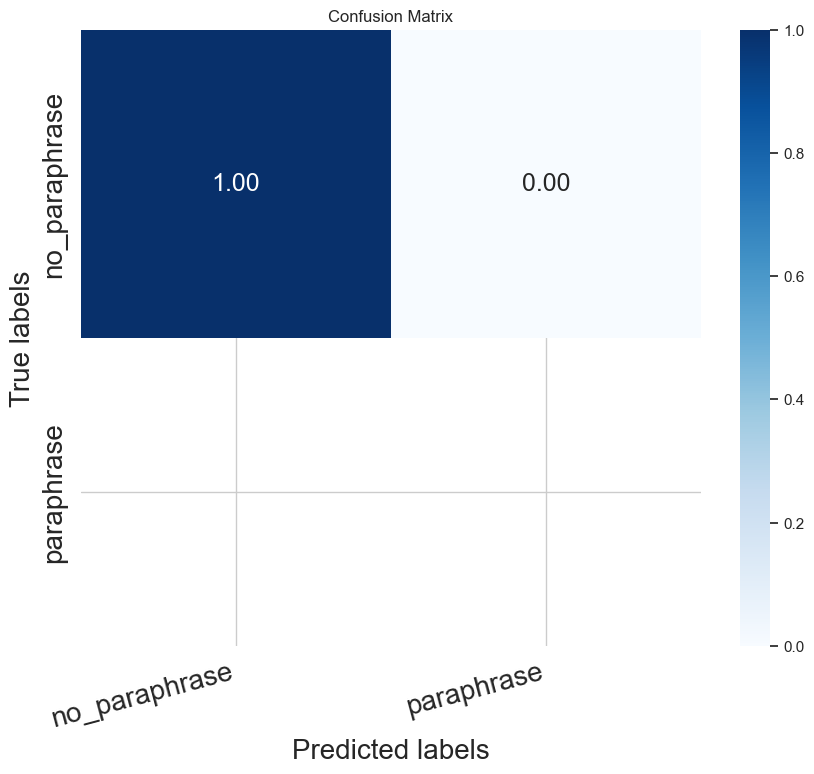

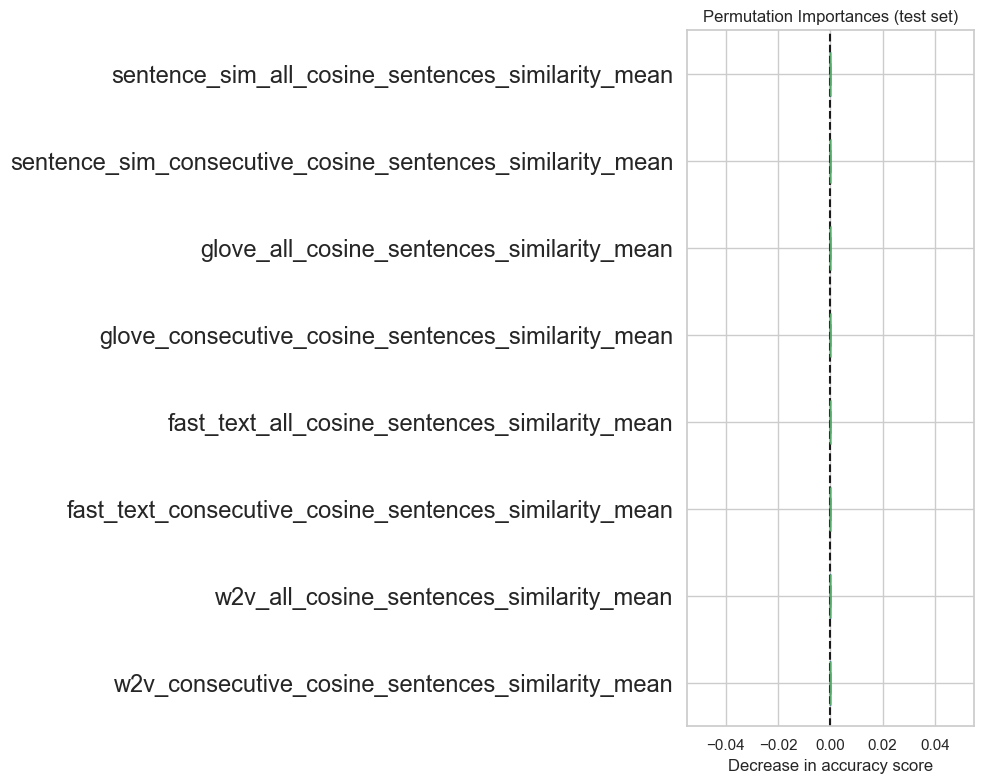

########################################
Training with wmd_mean_sim_metrics
Accuracy: 1.0
F1 Score: 1.0


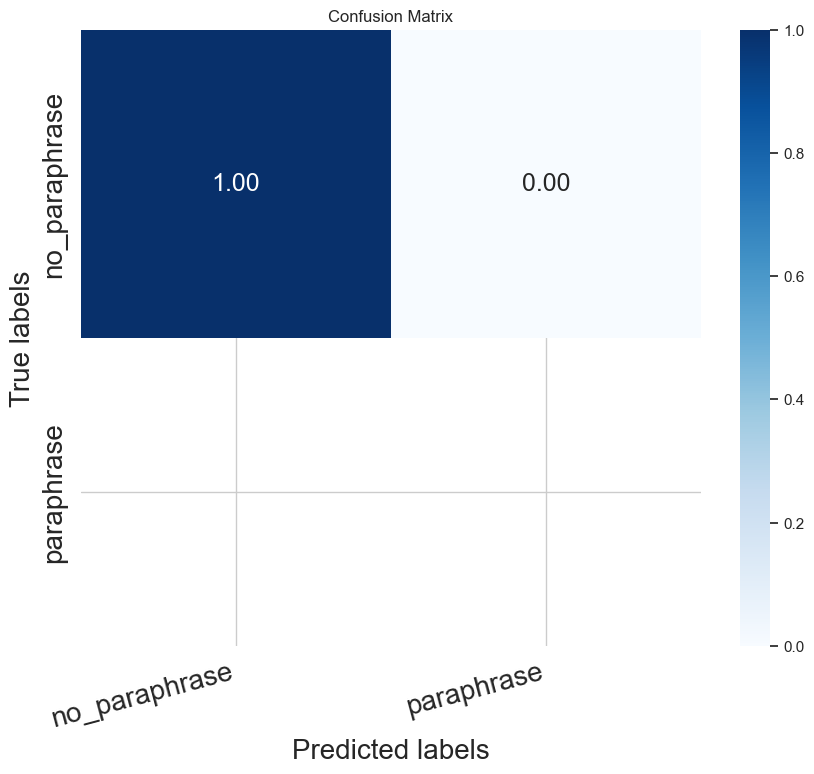

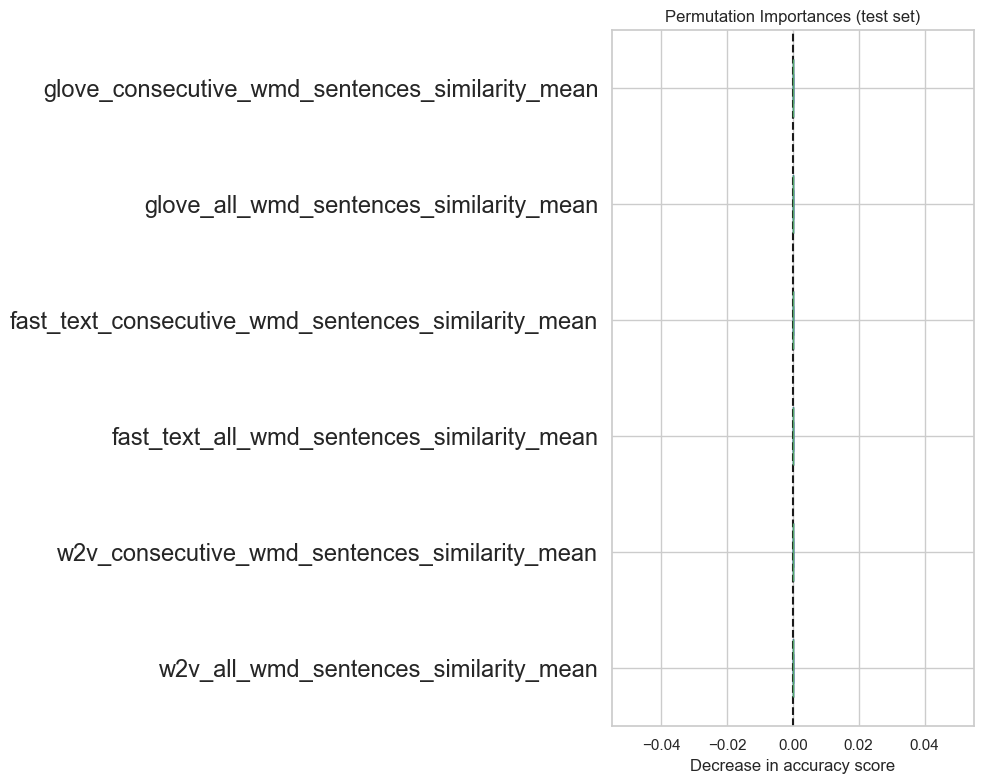

In [42]:
psm_dataset_density = dataset.loc[matched_indices].copy()

y_name = "has_paraphrase"
psm_dataset_density['cat_label'] = psm_dataset_density[y_name]
psm_num_to_label = {0: "no_paraphrase", 1: "paraphrase"}
df_results = train_and_evaluate_rf(features_dict_short,best_parameters_dict, psm_dataset_density, y_name="cat_label", num_to_label = psm_num_to_label)

In [39]:
matched_indices

Index([11152, 15722,   224, 15360, 14788, 10923, 11128, 11877, 15328, 16074,
       ...
       15516, 15735, 11471,  5372, 15870, 11537, 14773, 15109,    46, 11414],
      dtype='int64', length=5720)

In [31]:
test_index = psm.matched_ids["index"].tolist() + psm.matched_ids["matched_ID"].tolist()
len(test_index)

7174

In [34]:
set(index_to_keep) - set(test_index)

set()

In [17]:
index_to_keep_sim = from_treatment_name_to_index(test_dataset, 'treatment_1', target_list = mean_sim_metrics)

In [26]:
test_dataset

index                                        prompt  \
8000    8000  I had a terrifying dream last night in which   
15482  15482                            Today I am feeling   
14228  14228  I had a terrifying dream last night in which   
12038  12038                            Today I am feeling   
16532  16532                       When I was a little kid   
...      ...                                           ...   
8359    8359                  Most people start the day by   
2918    2918         The thing I like most in the world is   
4601    4601                  Most people start the day by   
12345  12345         The thing I like most in the world is   
6798    6798                           I worry a lot about   

                                          generated_text model_name  \
8000   I had a terrifying dream last night in which w...     pythia   
15482  Today I am feeling so much better". "It's all ...     pythia   
14228  I had a terrifying dream last night in which m...       gpt2   
12038  Today I am feeling a little better. The doctor...       gpt2   
16532  When I was a little kid, I used to play with L...     pythia   
...                                                  ...        ...   
8359   Most people start the day by taking a walk or ...     pythia   
2918   The thing I like most in the world is that I a...       gpt2   
4601   Most people start the day by learning to breat...       gpt2   
12345  The thing I like most in the world is to see a...       gpt2   
6798   I worry a lot about what's going to happen to ...     pythia   

       temperature  num_beams text llm_model paraphrase_model  \
8000      2.141649          5   -1    pythia    gpt-3.5-turbo   
15482     0.978819          4   -1    pythia    gpt-3.5-turbo   
14228     4.985790          4   -1      gpt2    gpt-3.5-turbo   
12038     2.013676          5   -1      gpt2    gpt-3.5-turbo   
16532     2.054634          4   -1    pythia    gpt-3.5-turbo   
...            ...        ...  ...       ...              ...   
8359      2.605027          5   -1    pythia    gpt-3.5-turbo   
2918      2.543140          5   -1      gpt2    gpt-3.5-turbo   
4601      4.811909          5   -1      gpt2    gpt-3.5-turbo   
12345     2.945746          5   -1      gpt2    gpt-3.5-turbo   
6798      1.019989          4   -1    pythia    gpt-3.5-turbo   

                                            altered_text  ...  lasso_based  \
8000   I had a terrifying dream last night in which w...  ...     0.582000   
15482  Today I am feeling so much better. Its all rig...  ...     0.511422   
14228  I had a terrifying dream last night in which m...  ...     0.619010   
12038  Today I am feeling a little better. The doctor...  ...     0.668884   
16532  When I was a little kid I used to play with Le...  ...     0.423586   
...                                                  ...  ...          ...   
8359   Most people start the day by taking a walk or ...  ...     0.599185   
2918   The thing I like most in the world is that I a...  ...     0.557845   
4601   Most people start the day by learning to breat...  ...     0.636959   
12345  The thing I like most in the world is to see a...  ...     0.654328   
6798   I worry a lot about whats going to happen to m...  ...     0.560528   

      lasso_based_std lasso_based_ci  global_topic_structure  \
8000         0.377587       0.427279                0.000000   
15482        0.238596       0.269996                0.000000   
14228        0.134085       0.151732                0.000000   
12038        0.149129       0.168755                0.000000   
16532        0.132353       0.149771                0.000000   
...               ...            ...                     ...   
8359         0.409344       0.463216                0.817457   
2918         0.167366       0.189392                0.000000   
4601         0.407248       0.460844                0.869575   
12345        0.352003       0.398329               

In [25]:
len(index_to_keep_density)

7173

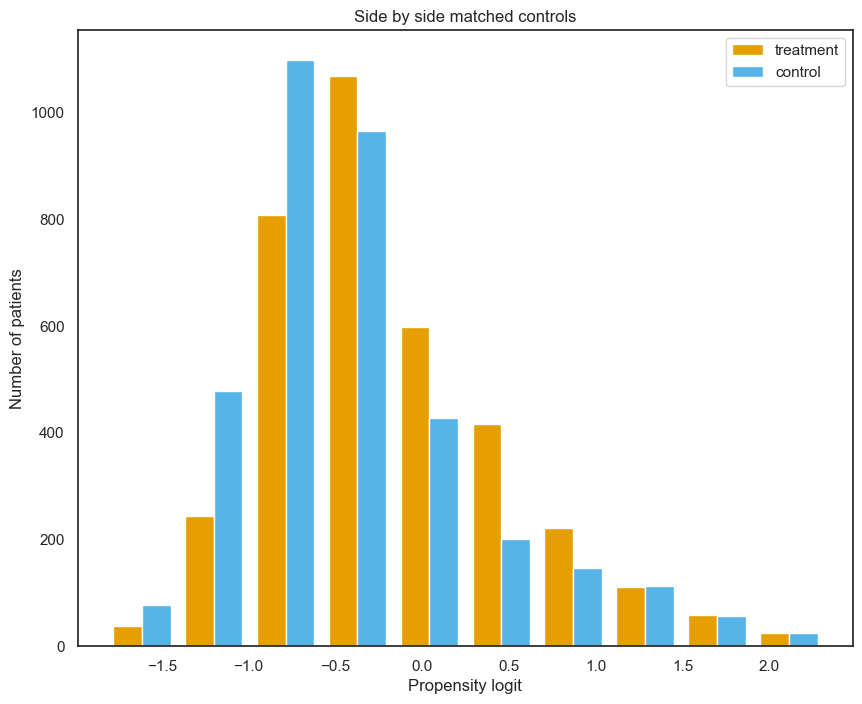

In [24]:
index_to_keep_density = from_treatment_name_to_index(test_dataset, 'treatment_1', target_list = density)

In [20]:
len(set(index_to_keep) - set(index_to_keep_sim))

995

In [21]:
len(index_to_keep)

7173

In [22]:
len(index_to_keep_sim)

7173

########################################
Training with density_features
Accuracy: 0.6467964314679643
F1 Score: 0.646440540852656


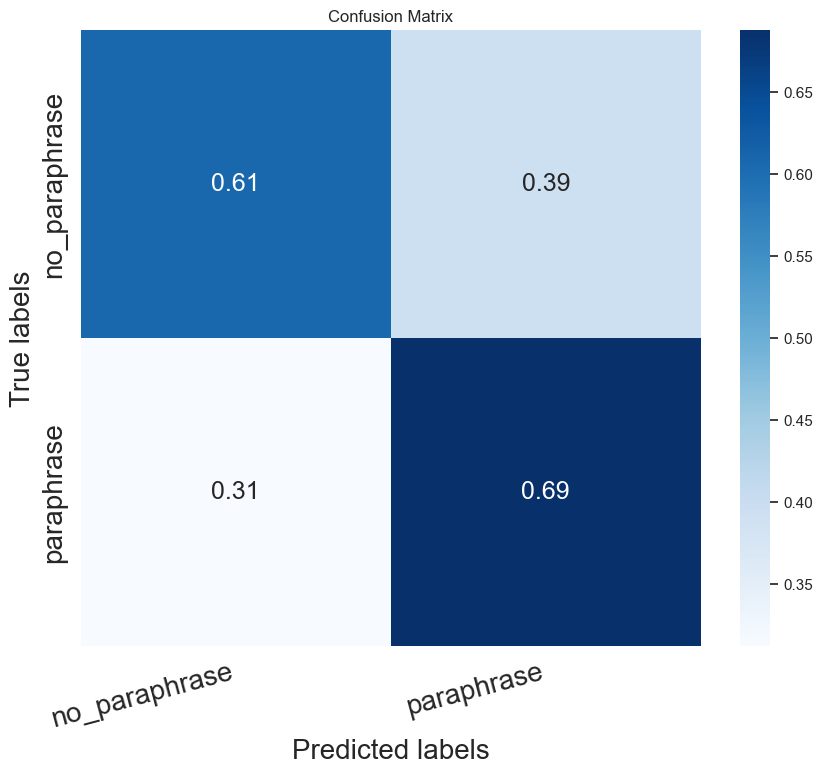

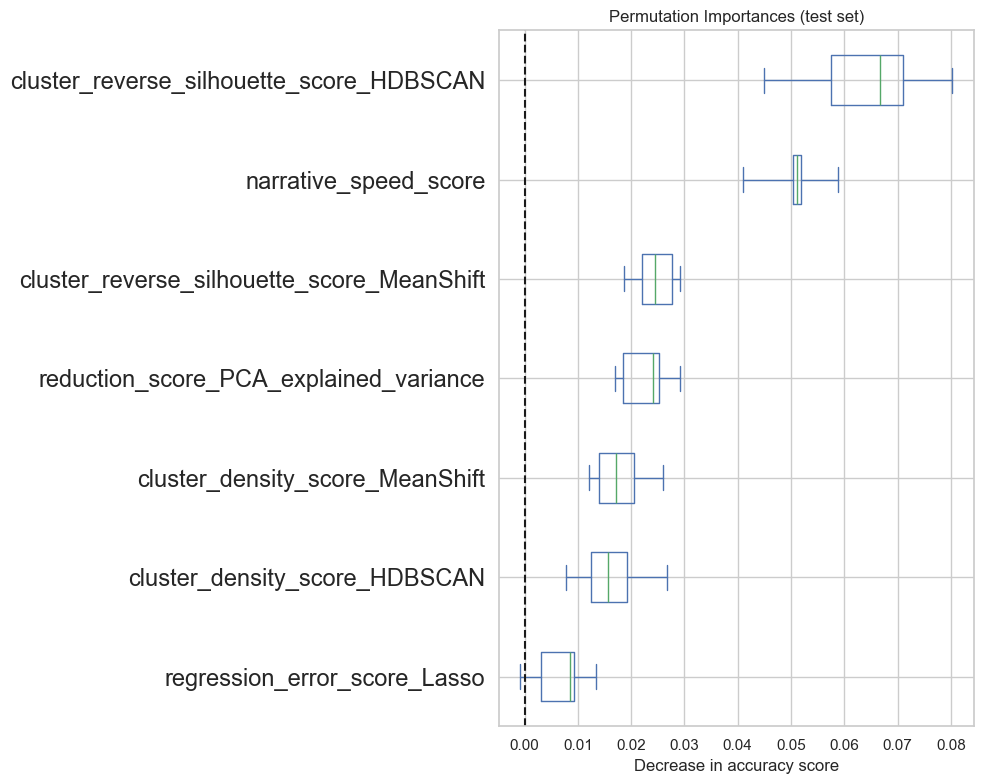

########################################
Training with cosine_mean_sim_metrics
Accuracy: 0.6220600162206001
F1 Score: 0.6218271141779539


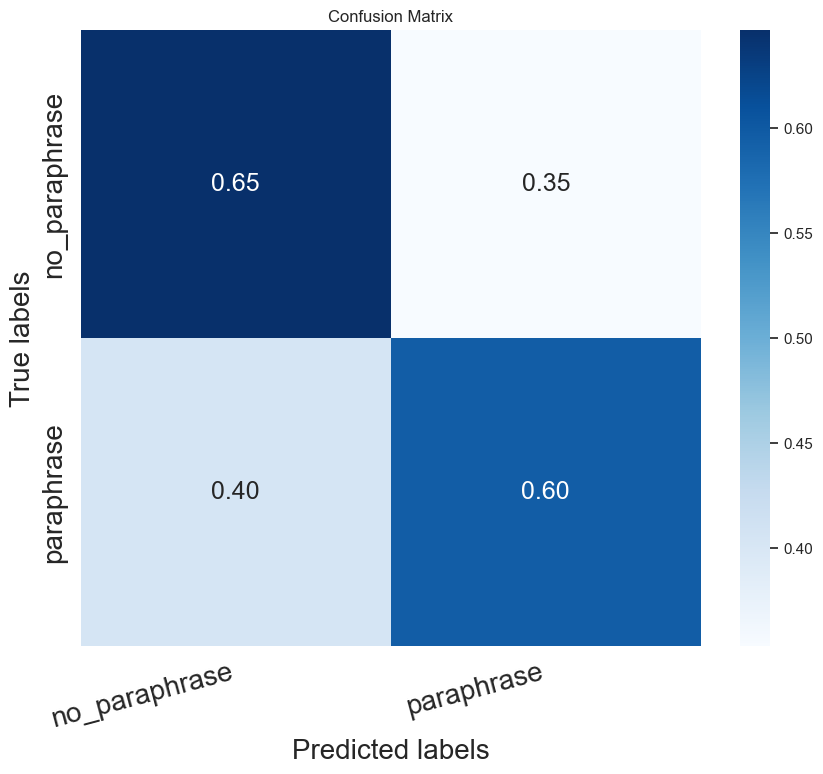

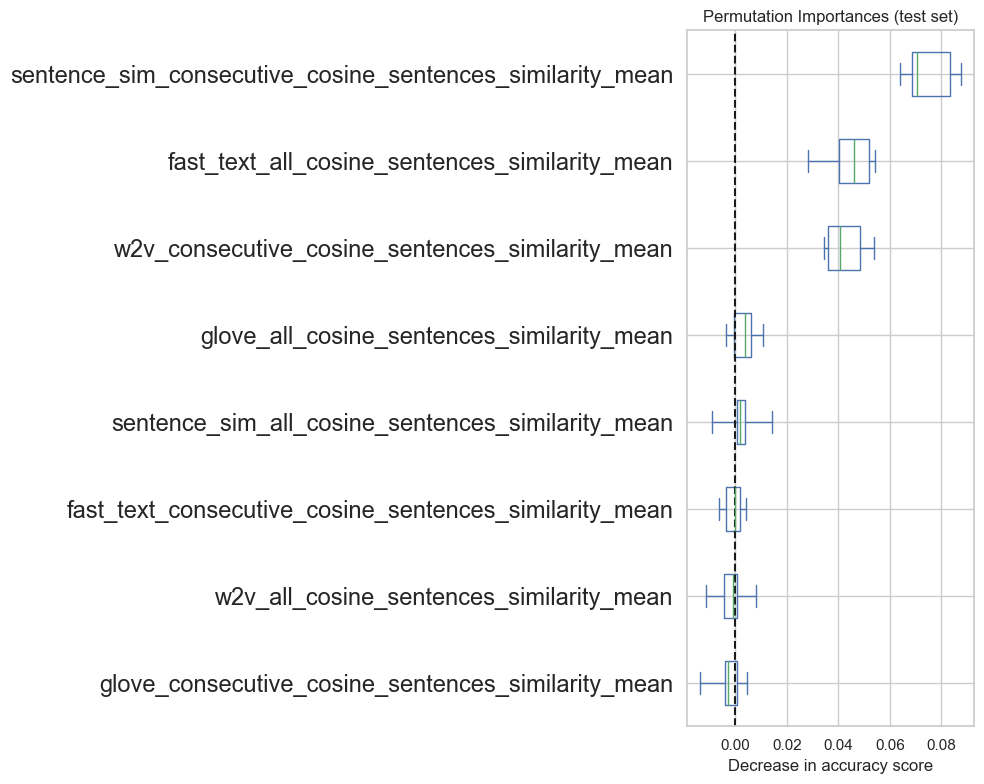

########################################
Training with wmd_mean_sim_metrics
Accuracy: 0.6411192214111923
F1 Score: 0.6355017658933863


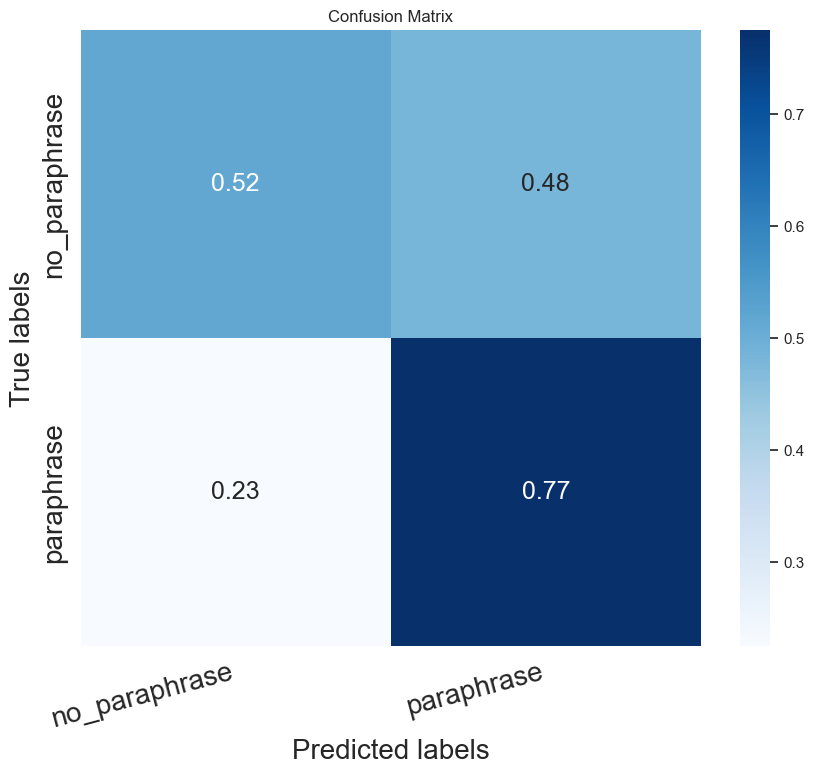

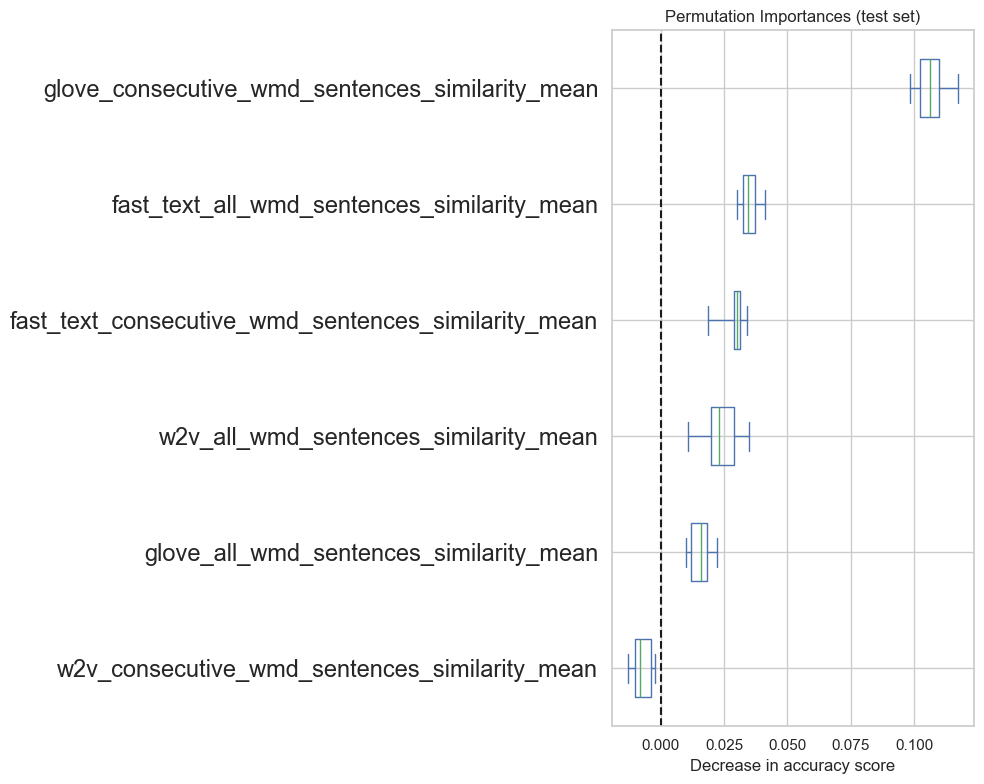

In [14]:
df_results = train_and_evaluate_rf(features_dict_short,best_parameters_dict, psm_dataset_density, y_name="cat_label", num_to_label = psm_num_to_label)